In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import warnings
import pandas as pd
import pickle
import polytope as pc
import math
import pypoman

import quantpy as qp

from tqdm.notebook import tqdm
from collections import defaultdict
from cycler import cycler
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d

titlesize = 48
labelsize = 52
legendsize = 32
xticksize = 40
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

warnings.filterwarnings('ignore', category=np.ComplexWarning)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
with open('../data/states.pkl', 'rb') as f:
    states = pickle.load(f)
states

,name,state,title,povm,n_meas
0,zero1,"Quantum object\narray([[1.+0.j, 0.+0.j],\n ...",$|0\rangle$,proj-set,1000
1,pure1,"Quantum object\narray([[0.85355+0.j , 0.25 ...",$\cos\frac{\pi}{8}|0\rangle + \sin\frac{\pi}{8...,proj-set,1000
2,fullymixed1,"Quantum object\narray([[0.5+0.j, 0. +0.j],\n ...",1-qubit fully mixed state,proj-set,1000
3,zero2,"Quantum object\narray([[1.+0.j, 0.+0.j, 0.+0.j...",$|00\rangle$,proj-set,10000
4,ghz2,"Quantum object\narray([[0.5+0.j, 0. +0.j, 0. +...",$|\Phi^+\rangle$,proj-set,10000
5,fullymixed2,"Quantum object\narray([[0.25+0.j, 0. +0.j, 0....",2-qubit fully mixed state,proj-set,10000
6,ghz3,"Quantum object\narray([[0.5+0.j, 0. +0.j, 0. +...",3-qubit GHZ state,proj-set,100000


In [3]:
with open('../data/processes.pkl', 'rb') as f:
    processes = pickle.load(f)
processes

,name,process,title,povm,n_meas
0,hadamard,Quantum channel with Choi matrix\narray([[ 0.5...,Hadamard gate,proj-set,1000
1,rxpi2,Quantum channel with Choi matrix\narray([[0.5+...,$RX(\pi/2)$,proj-set,1000
2,rypi2,Quantum channel with Choi matrix\narray([[ 0.5...,$RY(\pi/2)$,proj-set,1000
3,dep1,Quantum channel with Choi matrix\narray([[0.5+...,Fully depolarizing 1-qubit,proj-set,1000
4,cnot,Quantum channel with Choi matrix\narray([[1.+0...,CNOT,proj-set,100000
5,ms,Quantum channel with Choi matrix\narray([[ 0.5...,Mølmer–Sørensen gate,proj-set,100000


In [4]:
with open('../data/noised_processes.pkl', 'rb') as f:
    noised_processes = pickle.load(f)
noised_processes.head()

,name,process,title,povm,n_meas
0,hadamard,Quantum channel with Choi matrix\narray([[ 0.5...,Hadamard gate,proj-set,1000
1,rxpi2,Quantum channel with Choi matrix\narray([[0.5+...,$RX(\pi/2)$,proj-set,1000
2,rypi2,Quantum channel with Choi matrix\narray([[ 0.5...,$RY(\pi/2)$,proj-set,1000
3,dep1,Quantum channel with Choi matrix\narray([[0.5+...,Fully depolarizing 1-qubit,proj-set,1000
4,cnot,Quantum channel with Choi matrix\narray([[1.+0...,CNOT,proj-set,100000


In [5]:
def construct_intervals(intervals: dict, path: str):
    results = {}
    
    for name, interval in intervals.items():
        results[name] = interval()
    
    with open(path, 'wb') as f:
        pickle.dump(results, f)

In [6]:
def plot_intervals(intervals: dict = None, results_path: str = None, img_path: str = None, 
                   figsize: tuple = (20, 13), title: str = None,
                   legend: bool = True, show: bool = True, cc=None):
    if results_path:
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
    else:
        results = {}

        for name, interval in intervals.items():
            results[name] = interval()
        
    x_max = max([dist[np.asarray(CLs > 0.9).nonzero()[0][0]] for dist, CLs in results.values()]) 
    x_min = min([dist[np.asarray(CLs > 0.01).nonzero()[0][0]] for dist, CLs in results.values()])
    x_min -= (x_max - x_min) * 0.1
    x_max += (x_max - x_min) * 0.1
    
    if not cc:
        cc = (cycler(color=list('kbgry')) * cycler(linestyle=['-', '--', '-.', ':']))
    
    plt.figure(figsize=figsize, dpi=200)
    
    ax = plt.subplot(111)
    ax.grid()
    ax.set_xlabel('$\\delta$')
    ax.set_ylabel('$1 - \\epsilon$')
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((-0.05, 1.05))
    ax.set_prop_cycle(cc)
    if title:
        ax.set_title(title)
    
    for name, (dist, CLs) in results.items():
        ax.plot(dist, CLs, label=name)
    
    if legend:
        ax.legend()
    
    if img_path:
        plt.savefig(img_path, bbox_inches='tight')
        
    if show:
        plt.show()
    else:
        plt.close()
    
    return results

### States

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


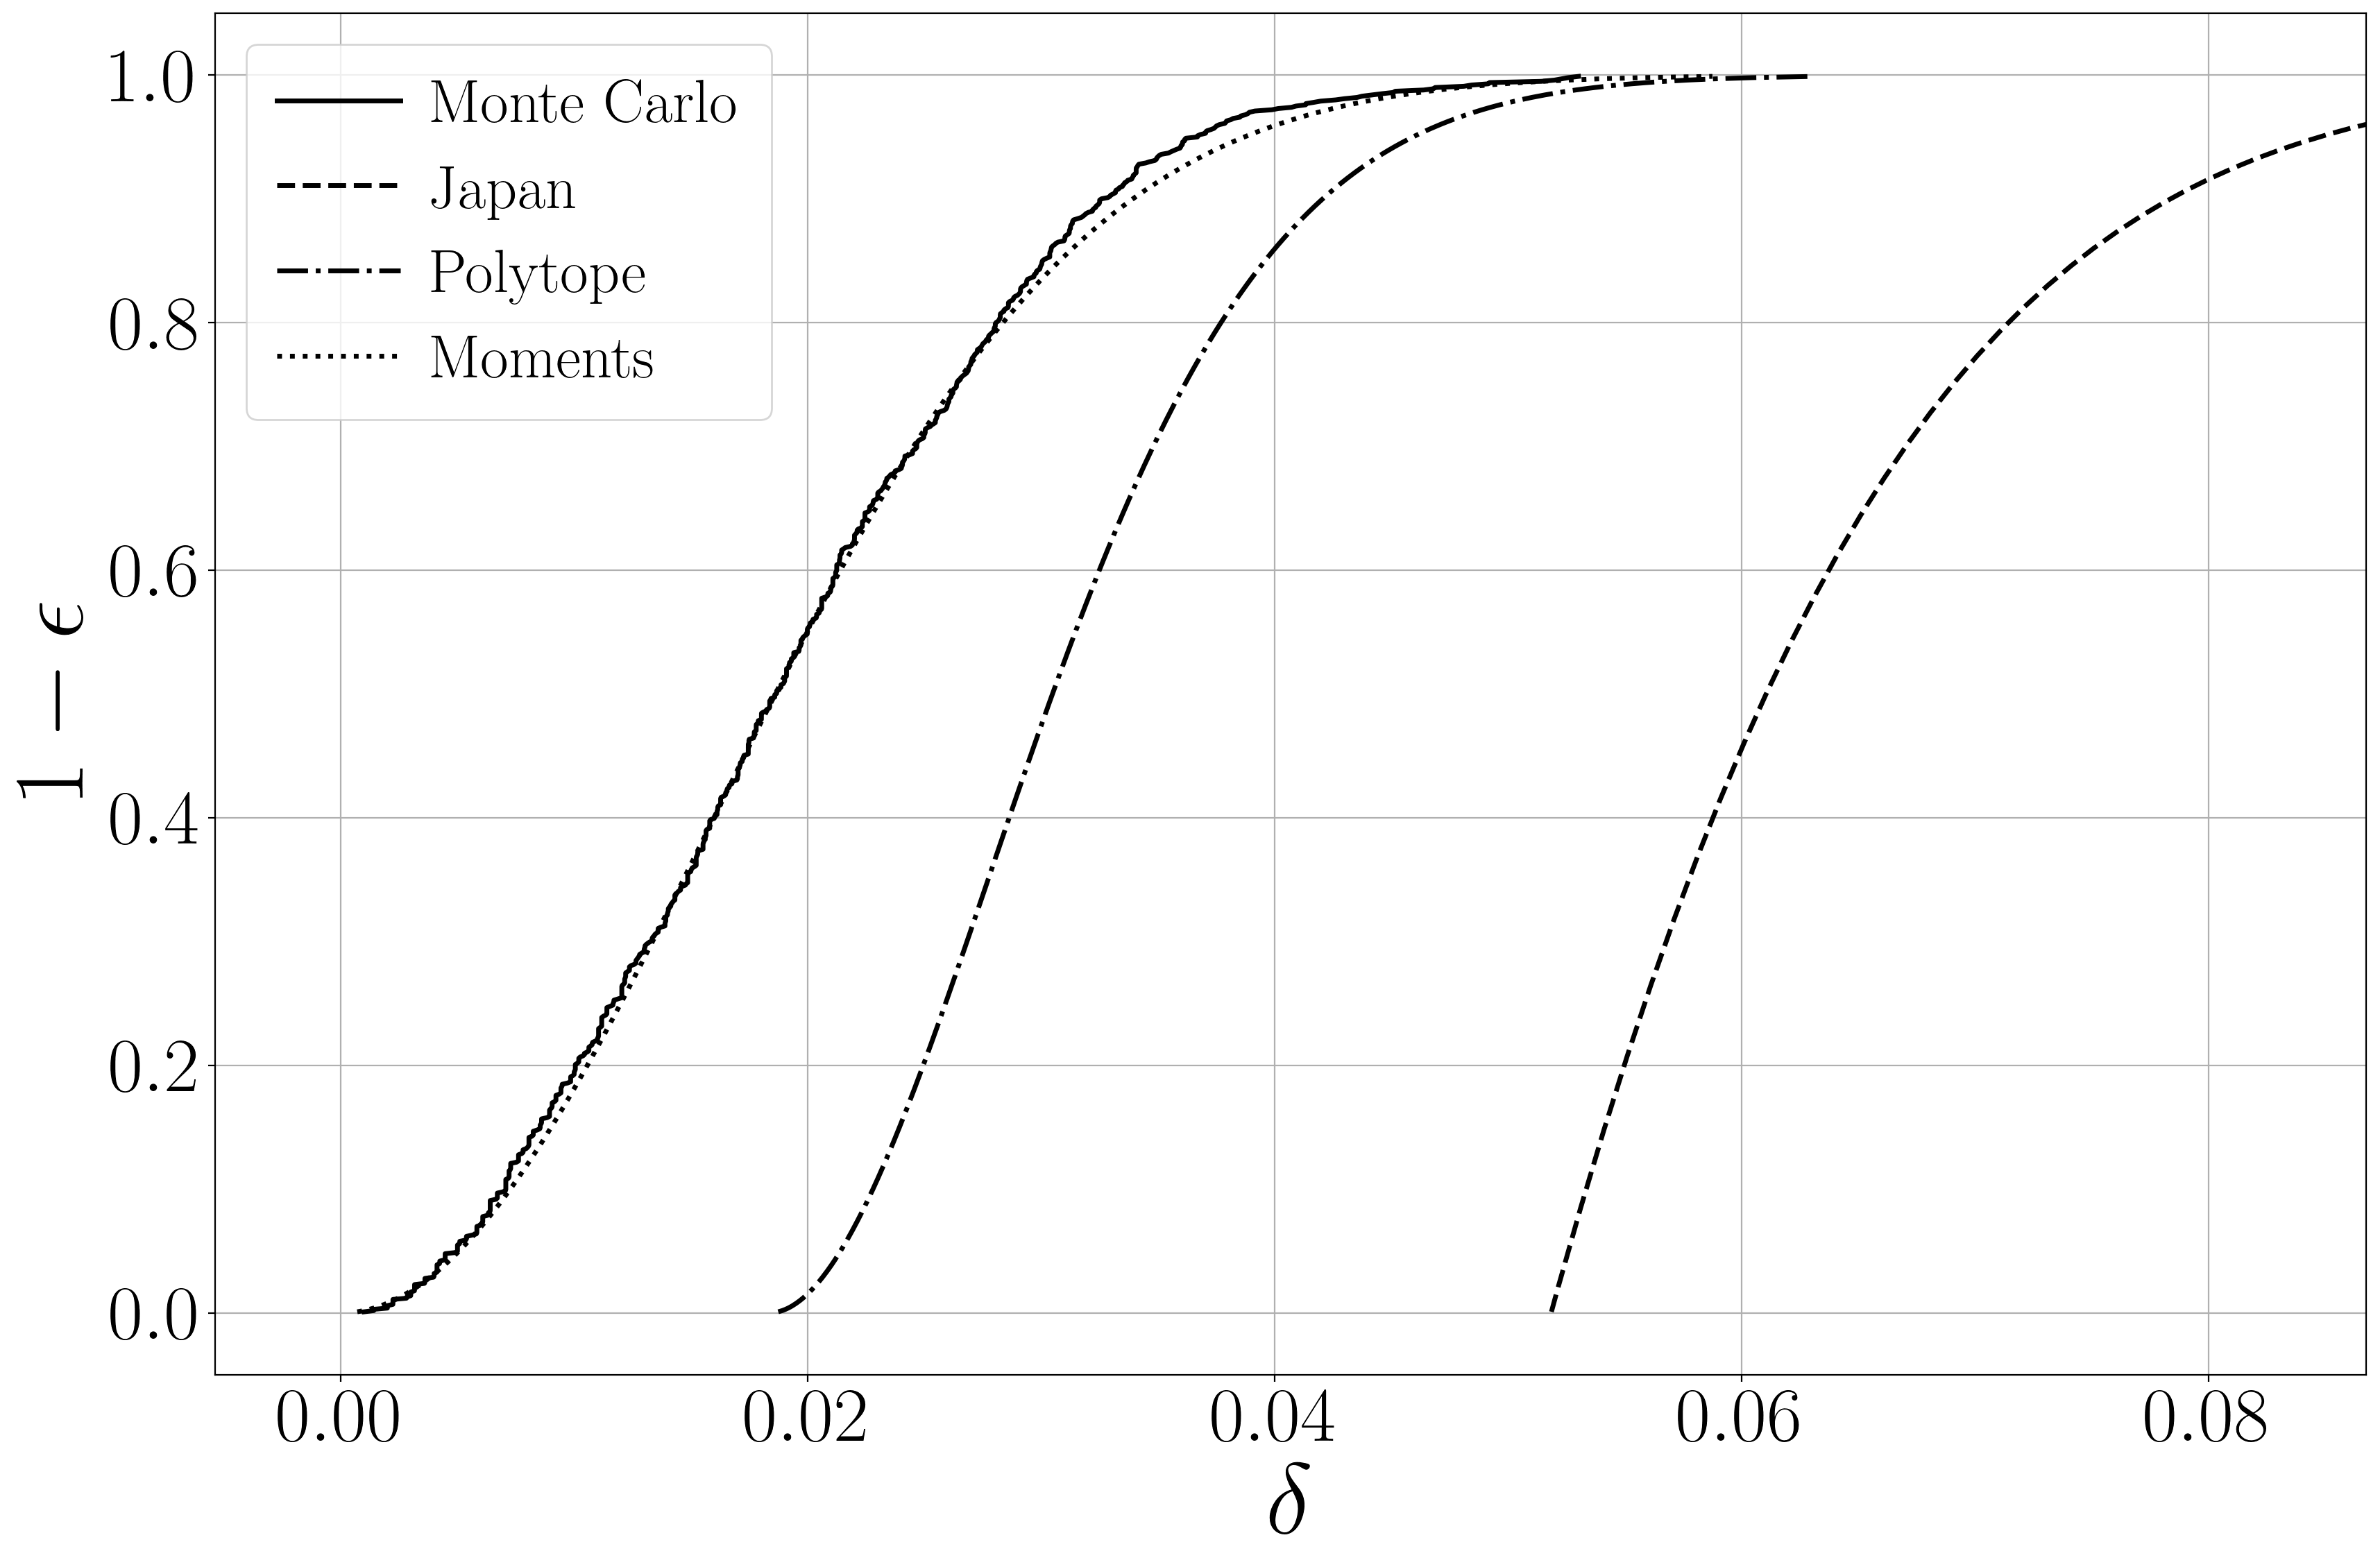

In [7]:
# cc = (cycler(color=list('kbgr')) * cycler(linestyle=['-', '-.', ':', (0, (5, 12))]))
cc = cycler(color=list('kbgr'))
for i in [0]:
    state = states.iloc[i]
    state_name = state['name']
    tmg = qp.StateTomograph(state['state'])
    tmg.experiment(int(state['n_meas']), povm='proj-set')
    intervals = {
        'Monte Carlo': qp.BootstrapStateInterval(tmg, state=state['state']),
        'Japan': qp.SugiyamaInterval(tmg),
        'Polytope': qp.WangInterval(tmg, method='bbox'),
        'Moments': qp.MomentInterval(tmg),
    }
    plot_intervals(intervals)

In [10]:
# cc = (cycler(color=list('kbgr')) * cycler(linestyle=['-', '-.', ':', (0, (5, 12))]))
cc = cycler(color=list('kbgr'))
for i in [0]:
    state = states.iloc[i]
    state_name = state['name']
    tmg = qp.StateTomograph(state['state'])
    tmg.experiment(int(state['n_meas']), povm='proj-set')
    intervals = {
        'Monte Carlo': qp.BootstrapStateInterval(tmg, state=state['state']),
        'Ref. [2]': qp.SugiyamaInterval(tmg),
        'Polytope': qp.WangInterval(tmg, method='bbox'),
        'Moments': qp.MomentInterval(tmg),
    }
    construct_intervals(intervals, f'../imgs/poster/{state_name}.pkl')

/home/esthete/Dropbox/RQC/quantpy/quantpy/tomography/interval.py:112: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt(distr.ppf(CLs)) * alpha * np.linalg.norm(A, ord=2)


In [9]:
# cc = (cycler(color=list('kbgr')) * cycler(linestyle=['-', '-.', ':', (0, (5, 12))]))
cc = cycler(color=list('kbgr'))
for i in [0, 1, 2, 4]:
    state = states.iloc[i]
    state_name = state['name']
    tmg = qp.StateTomograph(state['state'])
    tmg.experiment(int(state['n_meas']), povm='proj-set')
    intervals = {
        'Monte Carlo': qp.BootstrapStateInterval(tmg, state=state['state']),
        'Gamma': qp.MomentInterval(tmg, distr_type='gamma'),
        'Normal': qp.MomentInterval(tmg, distr_type='norm'),
    }
    construct_intervals(intervals, f'../imgs/poster/{state_name}_mom.pkl')

[autoreload of quantpy.tomography.interval failed: Traceback (most recent call last):
  File "/home/esthete/anaconda3/envs/quantpy/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded while calling a Python object
]


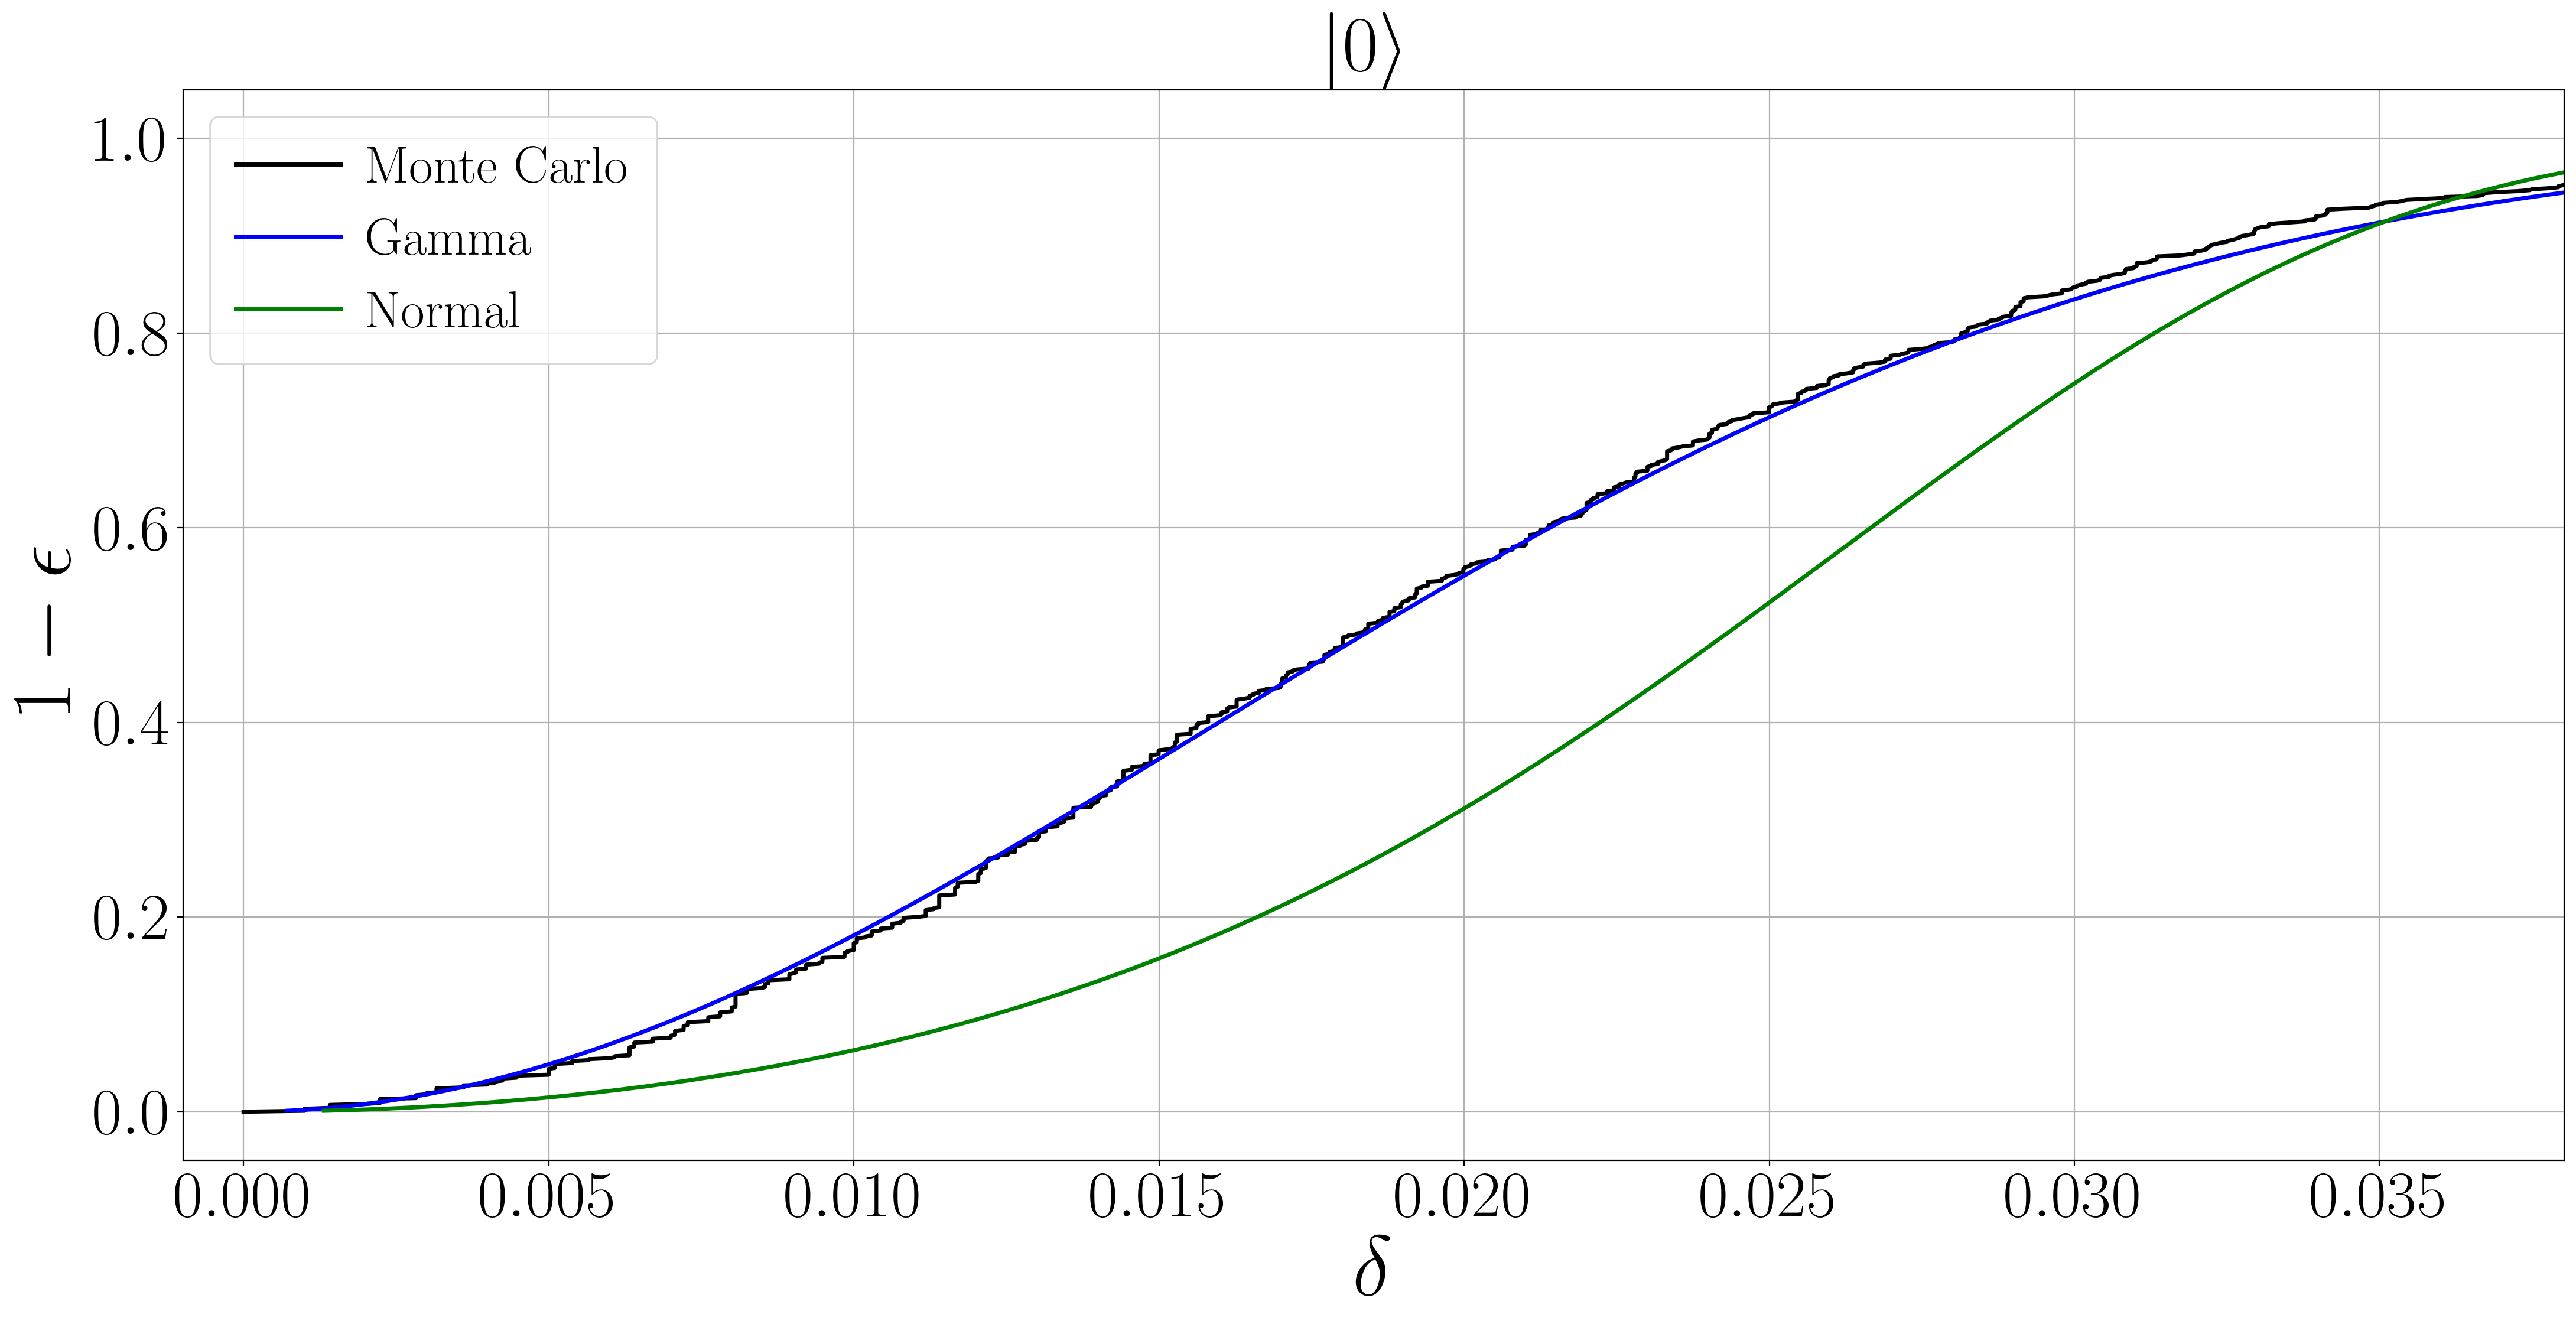

In [10]:
cc = cycler(color=list('kbgr'))
for i in [0]:
    state = states.iloc[i]
    state_name = state['name']
    results = plot_intervals(show=True,
                             results_path=f'../imgs/poster/{state_name}_mom.pkl',
                             title=state['title'], legend=True, cc=cc, figsize=(26, 12))

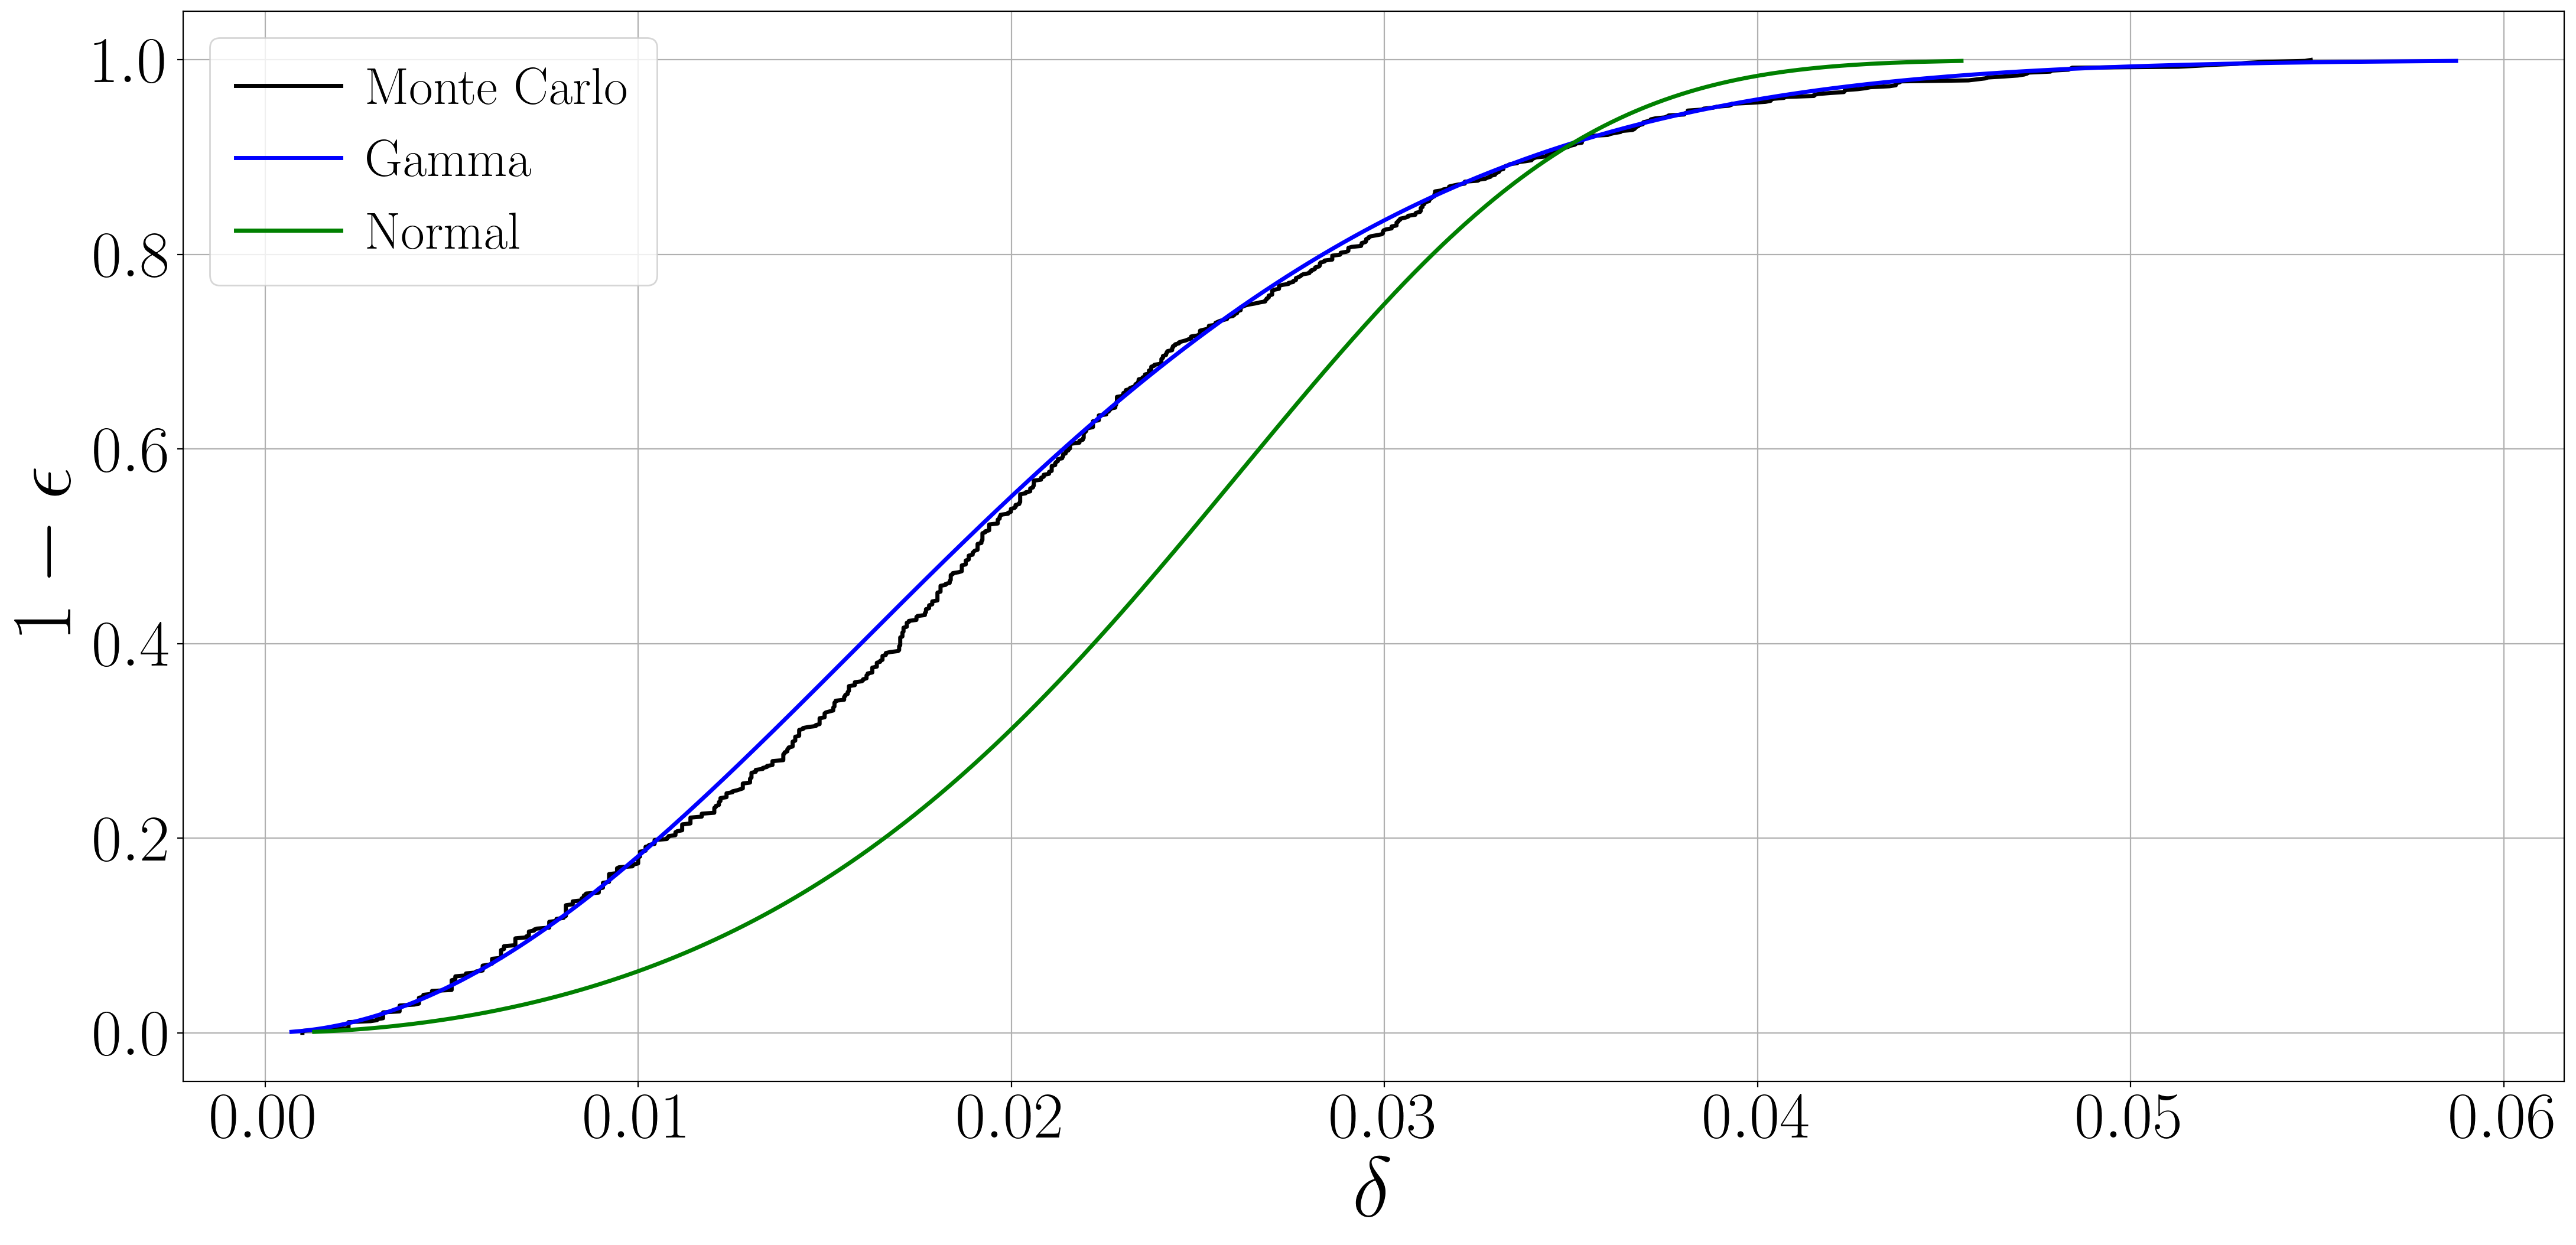

In [11]:
plt.figure(figsize=(26, 12), dpi=200)
    
ax = plt.subplot(111)
ax.grid()
ax.set_xlabel('$\\delta$')
ax.set_ylabel('$1 - \\epsilon$')
ax.set_prop_cycle(cc)

for name, (dist, CLs) in results.items():
    ax.plot(dist, CLs, label=name)
    
ax.legend()
plt.show()

### Processes

In [7]:
class ProcessWangInterval(qp.WangInterval):        
    def __call__(self):
        EPS = 1e-15
        dim = 4 ** self.tmg.channel.n_qubits
        bloch_dim = dim ** 2 - dim
        rho = self.tmg.point_estimate('lifp', cptp=False)
        
        povm_matrix = self.tmg.tomographs[0].povm_matrix
        n_measurements = self.tmg.tomographs[0].n_measurements

        frequencies = np.asarray([
            np.clip(tmg.raw_results / tmg.n_measurements[:, None], EPS, 1 - EPS)
            for tmg in self.tmg.tomographs
        ])
        
        eta_matrix = (np.reshape(povm_matrix * n_measurements[:, None, None] / np.sum(n_measurements),
                                  (-1, povm_matrix.shape[-1])) 
                       * povm_matrix.shape[0])
        Rt = np.asarray([rho.T.bloch for rho in self.tmg.input_basis.elements])
        pi_matrix = np.einsum("ij,ab->iajb", Rt, eta_matrix)
        pi_matrix = pi_matrix.reshape((pi_matrix.shape[0] * pi_matrix.shape[1],
                                       pi_matrix.shape[2] * pi_matrix.shape[3]))
        A = np.ascontiguousarray(pi_matrix[:, dim:]) * dim
        
        max_delta = self._count_delta(self.max_confidence, frequencies)
        
        if self.method == 'coarse':
            A_inv = _left_inv(A)
            prob_dim = povm_matrix.shape[0]
            coef1 = (np.linalg.norm(A_inv, ord=2)
                     * (self.tmg.povm_matrix.shape[1] - 1)
                     * np.sqrt(prob_dim))
            coef2 = np.linalg.norm(A_inv, ord=2) ** 2 * prob_dim
            max_dist = max(max_delta * coef1, np.sqrt(max_delta * coef2))
            dist_dummy = np.linspace(0, max_dist, self.n_points)
            deltas = np.maximum(dist_dummy / coef1, dist_dummy ** 2 / coef2)
        else:
            deltas = np.linspace(0, max_delta, self.n_points)
            dist_dummy = []
            for delta in tqdm(deltas):
                b = (np.clip(np.hstack(np.concatenate(frequencies, axis=0)) + delta, EPS, 1 - EPS) 
                     - pi_matrix[:, 0] * 2 ** self.tmg.channel.n_qubits)
                if self.method == 'exact':
                    vertices = pypoman.compute_polytope_vertices(A, b)
                    vertex_states = [_make_feasible(qp.Qobj(vertex)) for vertex in vertices]
                    if vertices:
                        radius = max([self.tmg.dst(vertex_state, rho) for vertex_state in
                                      vertex_states])
                    else:
                        radius = 0
                elif self.method == 'bbox':
                    lb, ub = pc.Polytope(A, b).bounding_box
                    volume = np.prod(ub - lb)
                    radius = ((volume * math.gamma(bloch_dim / 2 + 1)) ** (1 / bloch_dim)
                              / math.sqrt(math.pi))
                elif self.method == 'approx':
                    volume = compute_polytope_volume(pc.Polytope(A, b))
                    radius = ((volume * math.gamma(bloch_dim / 2 + 1)) ** (1 / bloch_dim)
                              / math.sqrt(math.pi))
                elif self.method == 'hit_and_run':
                    rho_bloch = rho.bloch[1:]
                    radius = find_max_distance_to_polytope(A, b, rho_bloch, rho_bloch)
                else:
                    raise ValueError("Invalid value for argument `mode`.")
                dist_dummy.append(radius)

        CLs_dummy = []
        for delta in deltas:
            CLs_dummy.append(self._count_confidence(delta, frequencies))
        cl_to_dist = interp1d(CLs_dummy, dist_dummy)
        CLs = np.linspace(0, self.max_confidence, self.n_points)
        dist = cl_to_dist(CLs)
        return dist, CLs
        
    def _count_confidence(self, delta, frequencies):
        EPS = 1e-15
        freq_plus_delta = np.clip(frequencies + delta, EPS, 1 - EPS)
        KL_divergence = (frequencies * np.log(frequencies / freq_plus_delta)
                         + (1 - frequencies) * np.log(
                    (1 - frequencies) / (1 - freq_plus_delta)))
        KL_divergence = np.where(freq_plus_delta < 1 - EPS, KL_divergence, np.inf)
        epsilons = np.exp(-self.tmg.tomographs[0].n_measurements[:, None] * KL_divergence)
        epsilons = np.where(np.abs(frequencies - 1) < 2 * EPS, 0, epsilons)
        return np.prod(np.maximum(1 - np.sum(epsilons, axis=-1), 0))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


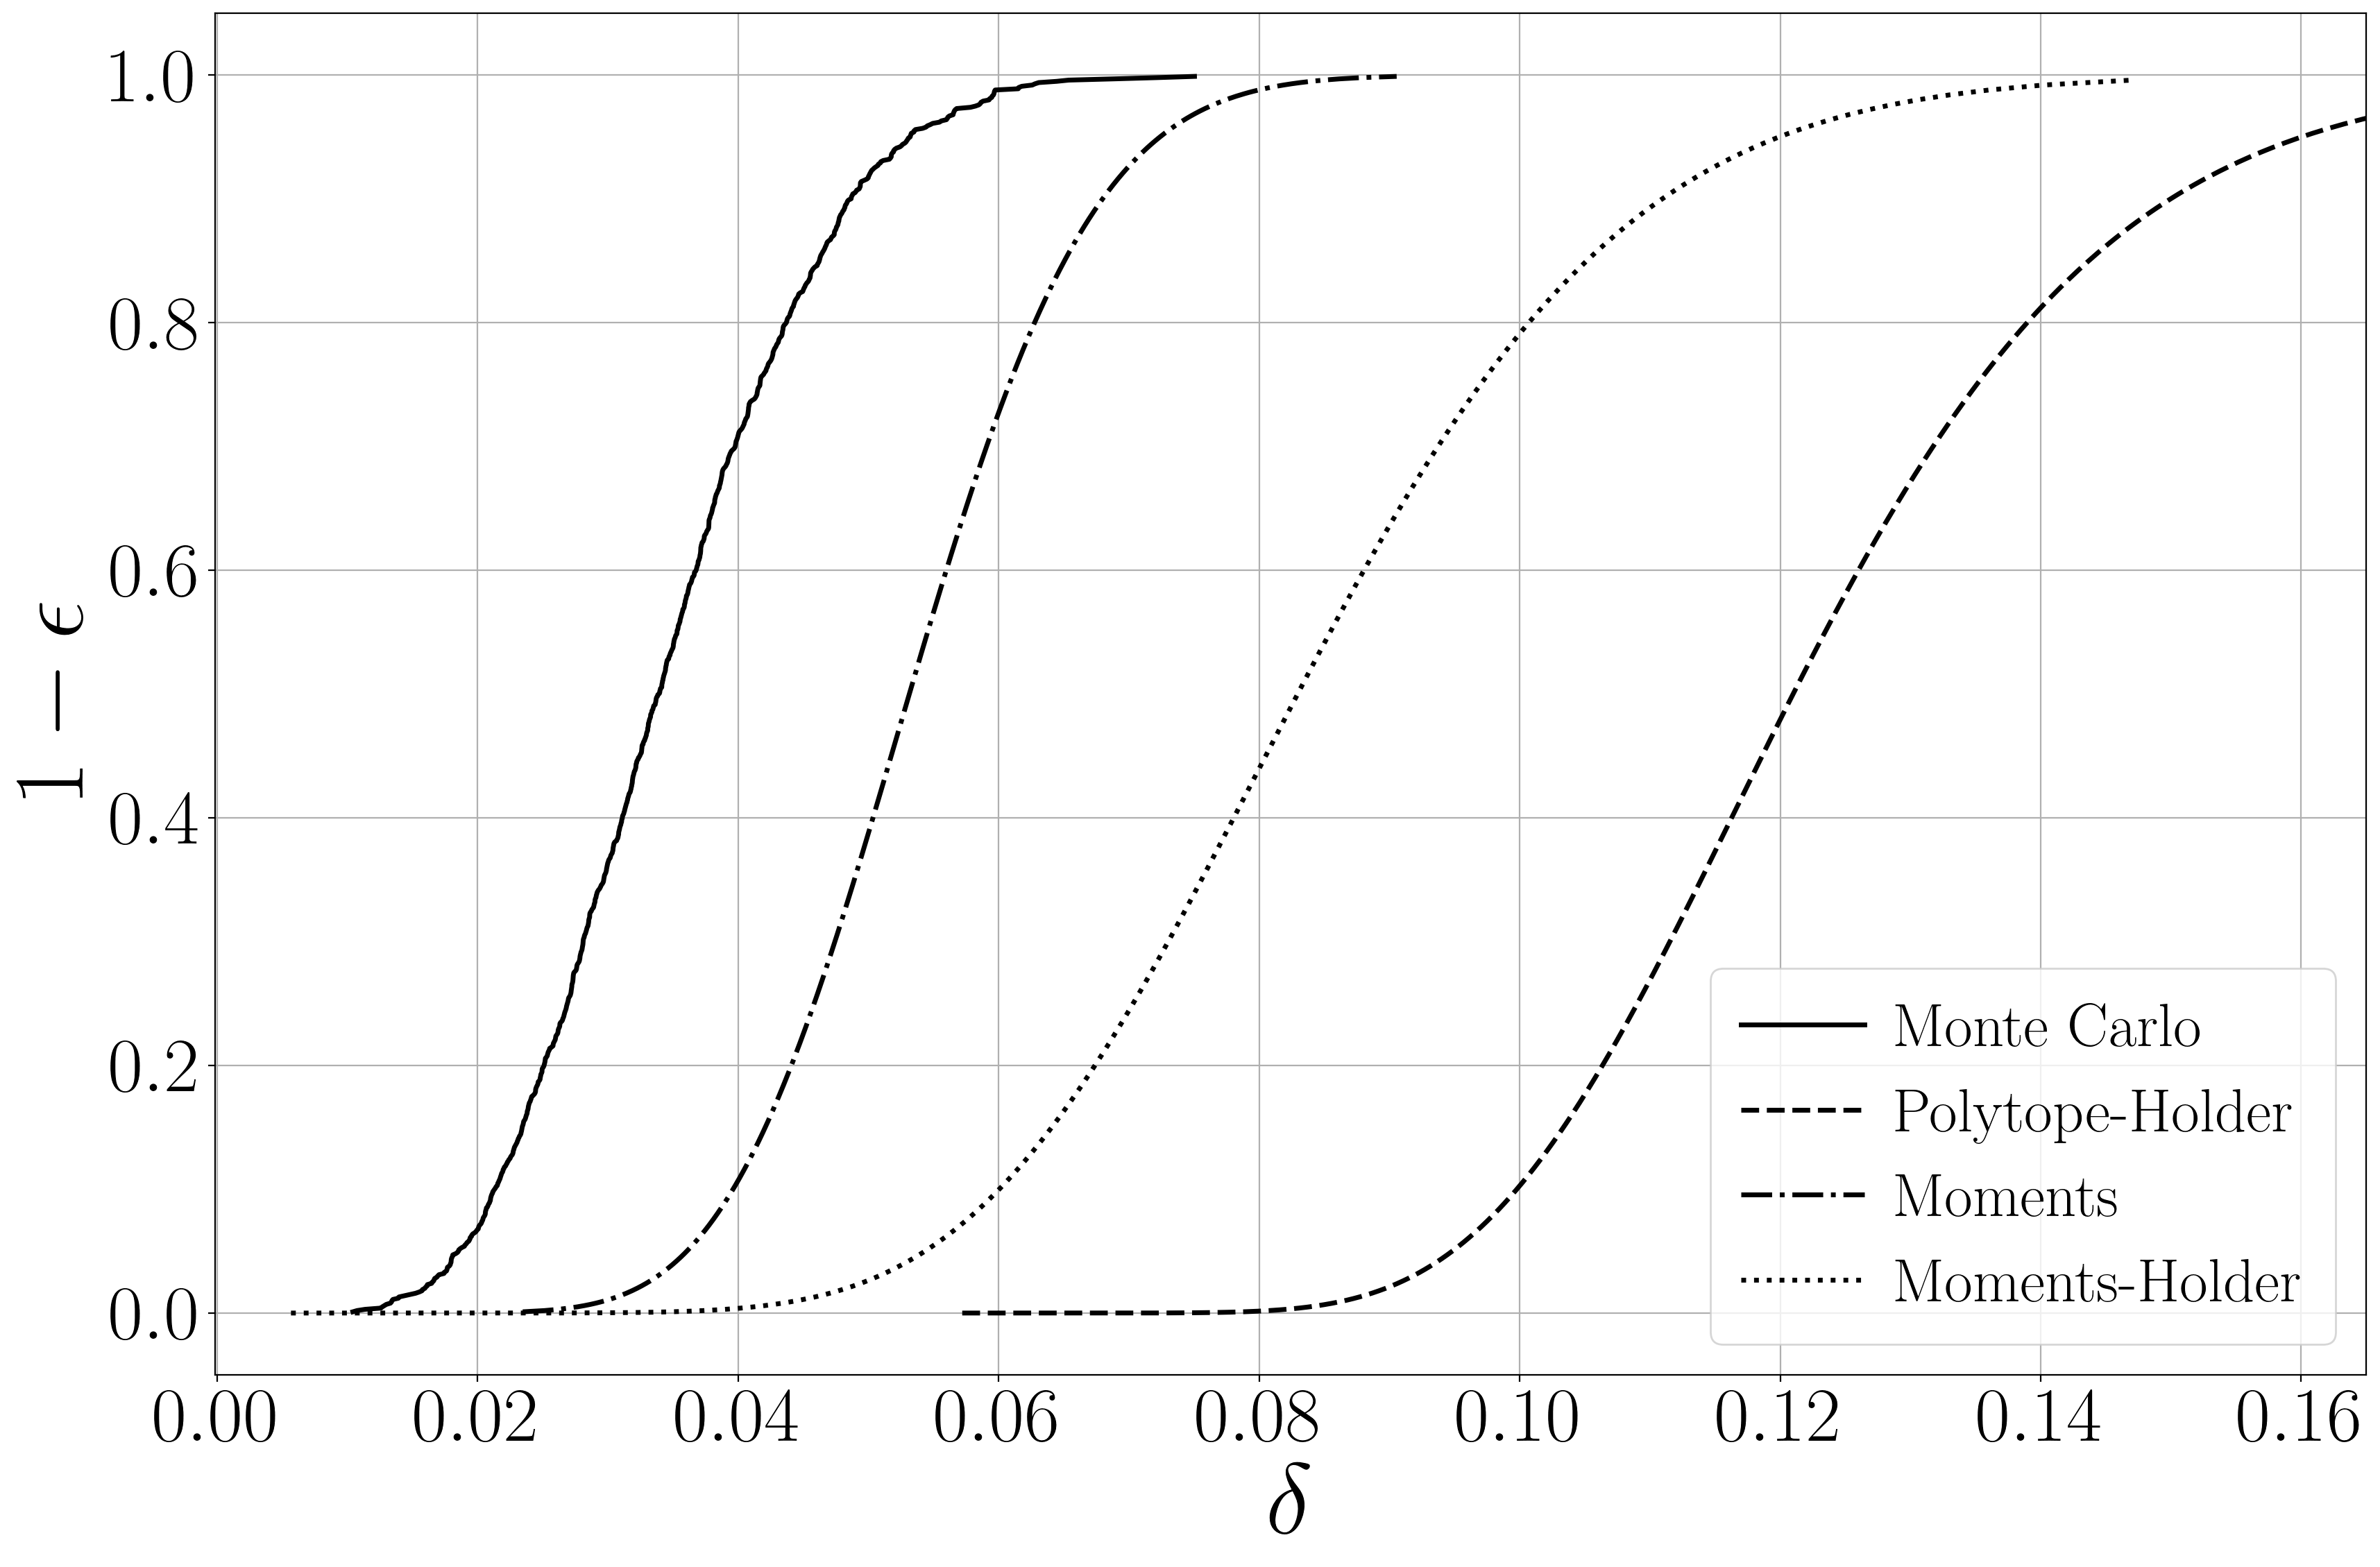

{'Monte Carlo': (array([0.01042, 0.01074, 0.01135, 0.01257, 0.01267, 0.01283, 0.01298,
         0.0133 , 0.01339, 0.01341, 0.01349, 0.01391, 0.01395, 0.01438,
         0.01479, 0.01523, 0.01551, 0.01572, 0.01576, 0.01595, 0.01601,
         0.01612, 0.01614, 0.01646, 0.01651, 0.01662, 0.01665, 0.0167 ,
         0.01686, 0.01693, 0.01703, 0.01741, 0.01744, 0.0176 , 0.01764,
         0.01765, 0.01768, 0.01782, 0.01789, 0.01791, 0.01795, 0.01796,
         0.01797, 0.01798, 0.01802, 0.01807, 0.01808, 0.0183 , 0.01845,
         0.01852, 0.01854, 0.01865, 0.01879, 0.01898, 0.01903, 0.01912,
         0.01918, 0.0193 , 0.01936, 0.01941, 0.01942, 0.01952, 0.01955,
         0.01963, 0.01978, 0.01988, 0.01994, 0.02004, 0.02007, 0.02008,
         0.02015, 0.02024, 0.0203 , 0.02031, 0.02038, 0.02041, 0.02043,
         0.02049, 0.02055, 0.02058, 0.02059, 0.0206 , 0.02062, 0.02066,
         0.02067, 0.02076, 0.02079, 0.02083, 0.0209 , 0.02093, 0.02097,
         0.02098, 0.02099, 0.02102, 0.02105, 0.02

In [7]:
# cc = (cycler(color=list('kbgr')) * cycler(linestyle=['-', '-.', ':', (0, (5, 12))]))
cc = cycler(color=list('kbgry'))
process = processes.iloc[0]
process_name = process['name']
tmg = qp.ProcessTomograph(process['process'], input_states='sic')
tmg.experiment(int(process['n_meas']), povm=process['povm'])
process_hat = tmg.point_estimate('lifp')
intervals = {
    'Monte Carlo': qp.BootstrapProcessInterval(tmg, channel=process['process']),
    'Polytope-Holder': qp.HolderInterval(tmg, kind='wang', wang_method='bbox'),
    'Moments': qp.MomentInterval(tmg),
    'Moments-Holder': qp.HolderInterval(tmg, kind='moment'),
}
plot_intervals(intervals)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


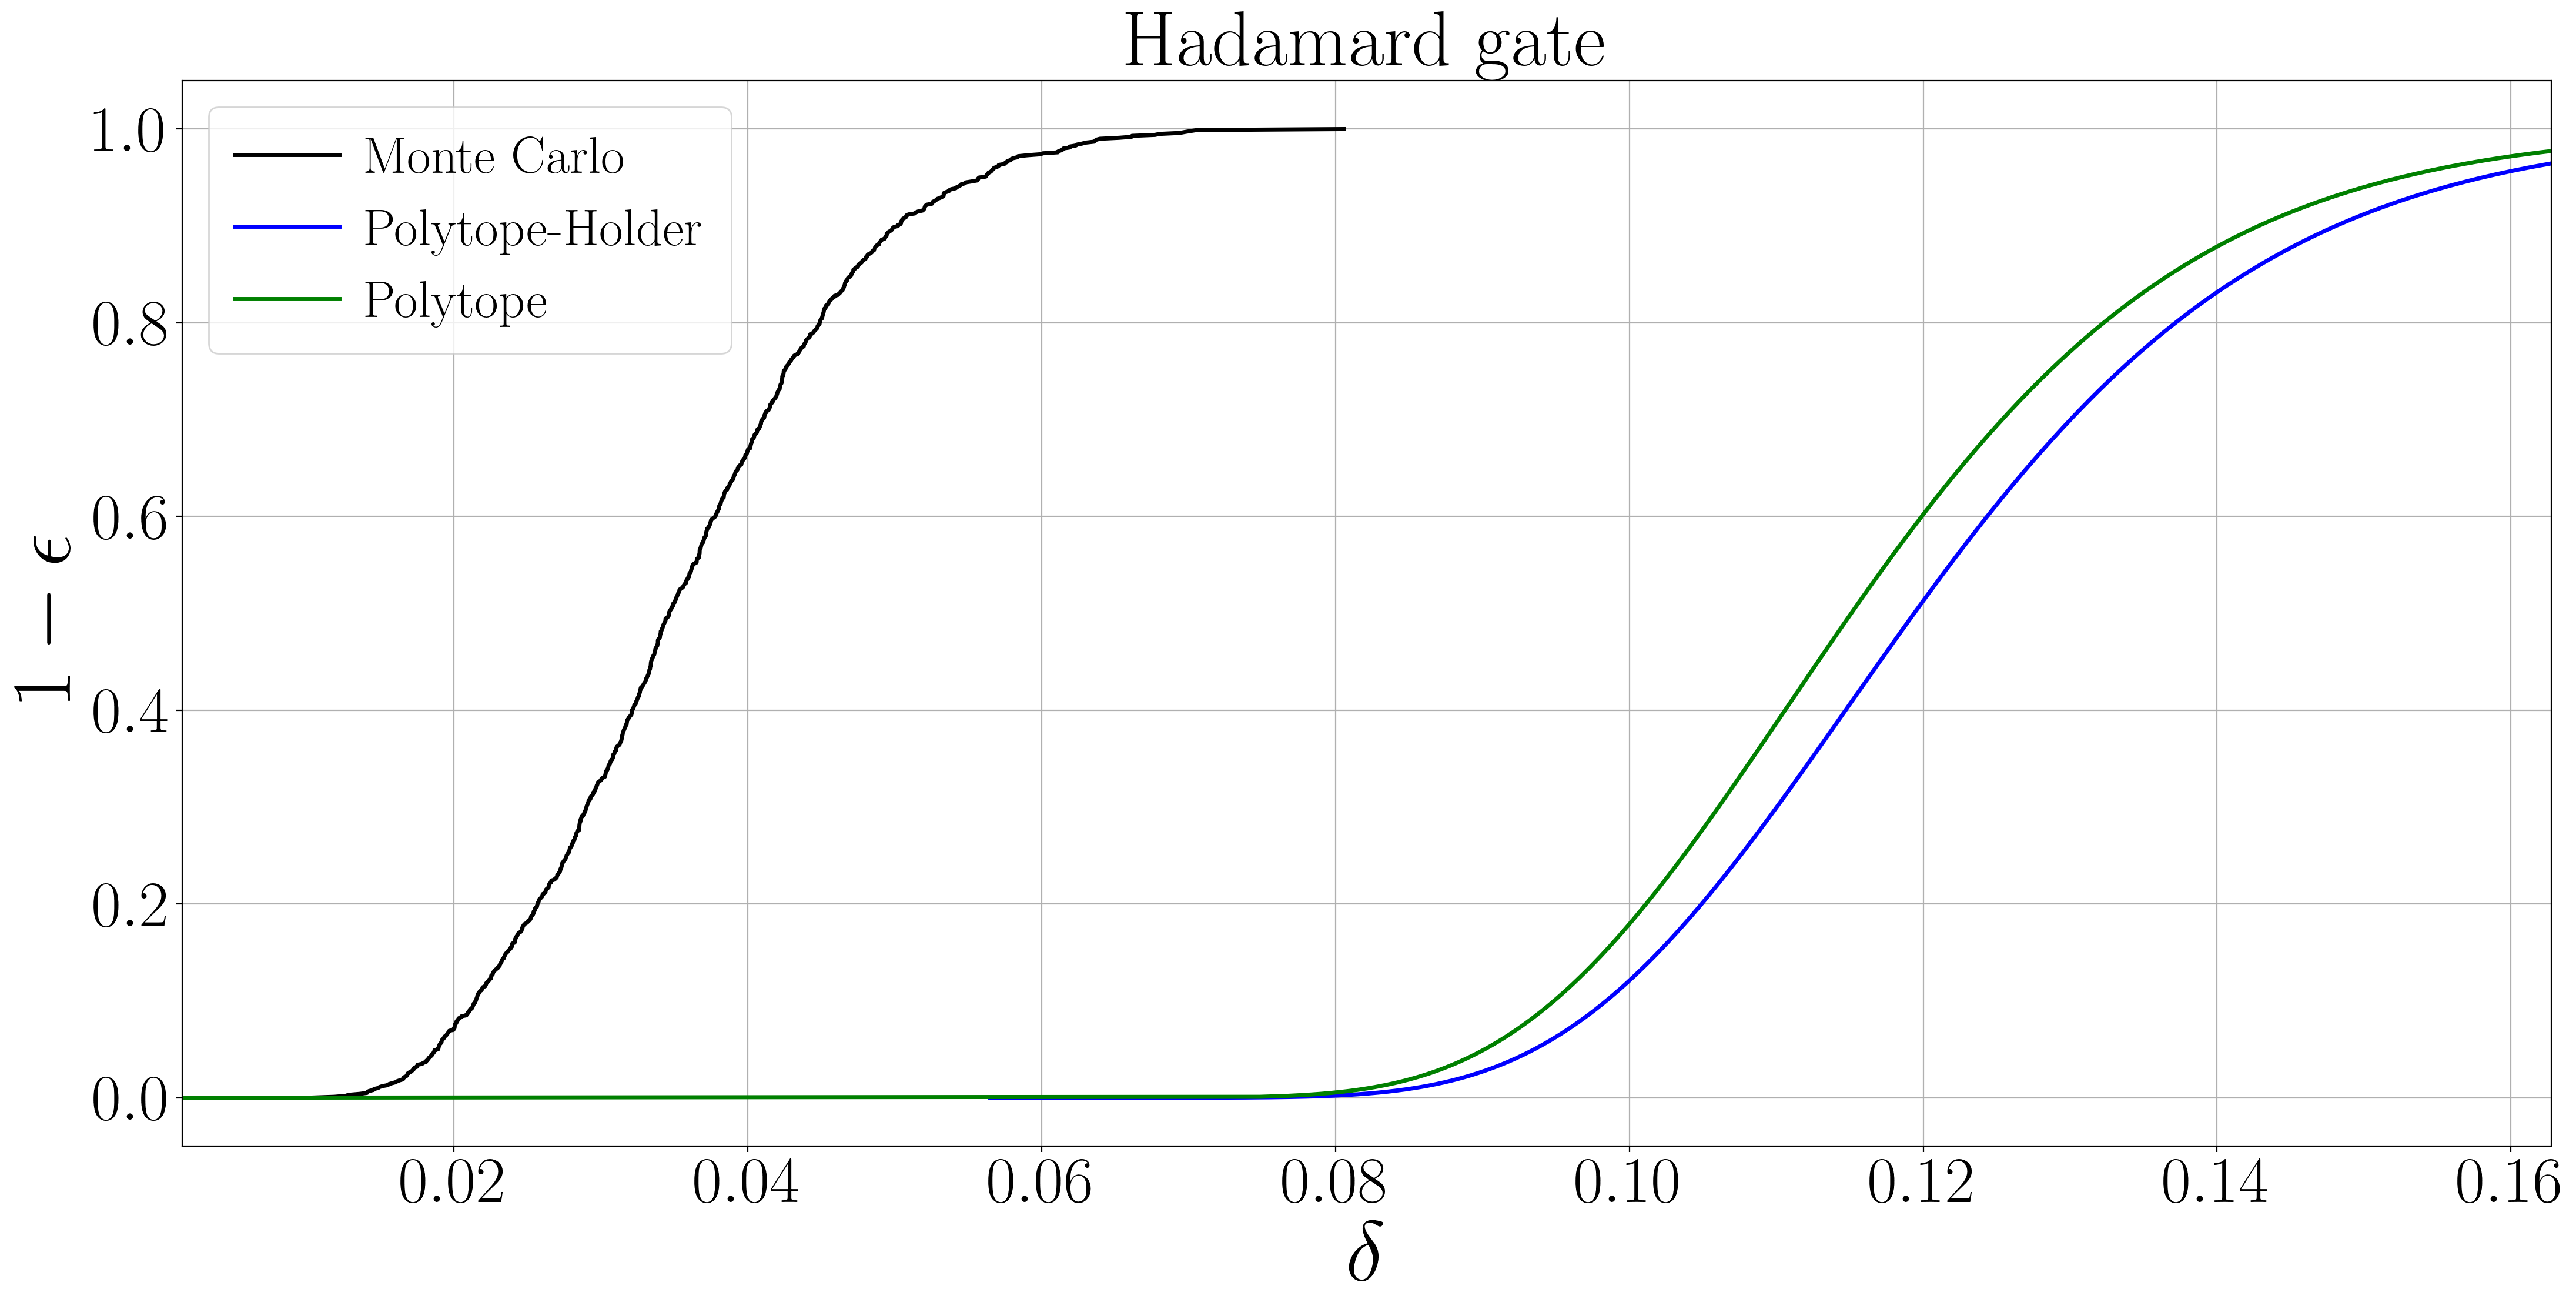

In [9]:
cc = cycler(color=list('kbgry'))
for i in [0]:
    process = processes.iloc[i]
    process_name = process['name']
    results = plot_intervals(show=True, img_path=f'../imgs/poster/{process_name}.png',
                             results_path=f'../imgs/poster/{process_name}.pkl',
                             title=process['title'], legend=True, cc=cc, figsize=(26, 12))

In [21]:
for _, process in tqdm(list(noised_processes.iterrows())[:12]):
    if not (process['name'].startswith("hadamard") or process['name'].startswith("cnot")):
        continue
    process_name = process['name']
    tmg = qp.ProcessTomograph(process['process'])
    tmg.experiment(process['n_meas'], povm=process['povm'])
    process_hat = tmg.point_estimate('lifp')
    intervals = {
        'Polytope (bbox)': HolderCorrectInterval(tmg, kind='wang', wang_method='bbox'),
        'Japan': HolderCorrectInterval(tmg, kind='sugiyama'),
        'Polytope (coarse)': HolderCorrectInterval(tmg, kind='wang', wang_method='coarse'),
        'True': qp.BootstrapProcessInterval(tmg, channel=process['process'])
    }
    if process['process'].n_qubits == 1:
        intervals['Polytope (exact)'] = HolderCorrectInterval(tmg, kind='wang', wang_method='exact')
    construct_intervals(intervals, f'../results/process/{process_name}.pkl')

In [25]:
cc = (cycler(color=list('kgkrk')) + cycler(linestyle=['-', '-', ':', '-', (0, (5, 12))]))
for _, process in tqdm(list(noised_processes.iterrows())):
    if not (process['name'].startswith("hadamard") or process['name'].startswith("cnot")):
        continue
    process_name = process['name']
    results = plot_intervals(results_path=f'../results/process/{process_name}.pkl', show=False, 
                             img_path=f'../imgs/polytopes_paper/process/{process_name}.png', 
                             title=process['title'], legend=False, cc=cc, figsize=(18, 12))

FileNotFoundError: [Errno 2] No such file or directory: '../results/process/hadamard_0.25.pkl'

In [13]:
# bbox, japan, opnorm, vertex, 
cc = (cycler(color=list('kbgry')) * cycler(linestyle=['-', '-.', ':', (0, (5, 12))]))
for _, process in tqdm(processes.iterrows()):
    if process['process'].n_qubits == 1:
        continue
    process_name = process['name']
    tmg = qp.ProcessTomograph(process['process'])
    tmg.experiment(process['n_meas'], povm=process['povm'])
    intervals = {
#         'Polytope (bbox)': qp.HolderInterval(tmg, kind='wang', wang_method='bbox'),
        'Japan': qp.HolderInterval(tmg, kind='sugiyama'),
    }
    results, times = plot_intervals(intervals, show=False, 
                                    path=f'../imgs/polytopes_paper/process/{process_name}_no_opnorm.png', 
                                    title=None, legend=False, cc=cc, figsize=(12, 12))

In [9]:
cc = (cycler(color=list('kk')) + cycler(linestyle=['-', ':']))
# cc = (cycler(color=list('kyk')) + cycler(linestyle=['-', '-', ':']))
for _, process in tqdm(processes.iloc[-1:].iterrows()):
    process_name = process['name']
    tmg = qp.ProcessTomograph(process['process'])
    tmg.experiment(process['n_meas'], povm=process['povm'])
    intervals = {
        'Polytope (bbox)': qp.HolderInterval(tmg, kind='wang', wang_method='bbox'),
#         'Polytope (exact)': qp.HolderInterval(tmg, kind='wang', wang_method='exact'),
#         'Polytope (coarse)': qp.HolderInterval(tmg, kind='wang', wang_method='coarse'),
    }
    results, times = plot_intervals(intervals, show=False, 
                                    path=f'../imgs/process/{process_name}.png', 
                                    title=process['title'], legend=True, cc=cc)

## Compound graph

In [26]:
legend_elements = [Line2D([0], [0], linestyle='-', color='k', label='bounding box'),
                   Line2D([0], [0], linestyle='-', color='g', label='Ref. [18]'),
                   Line2D([0], [0], linestyle=':', color='k', label='operator norm'),
                   Line2D([0], [0], linestyle='-', color='r', label='Monte-Carlo simulation'),
                   Line2D([0], [0], linestyle=(0, (5, 12)), color='k', label='farthest vertex'),]

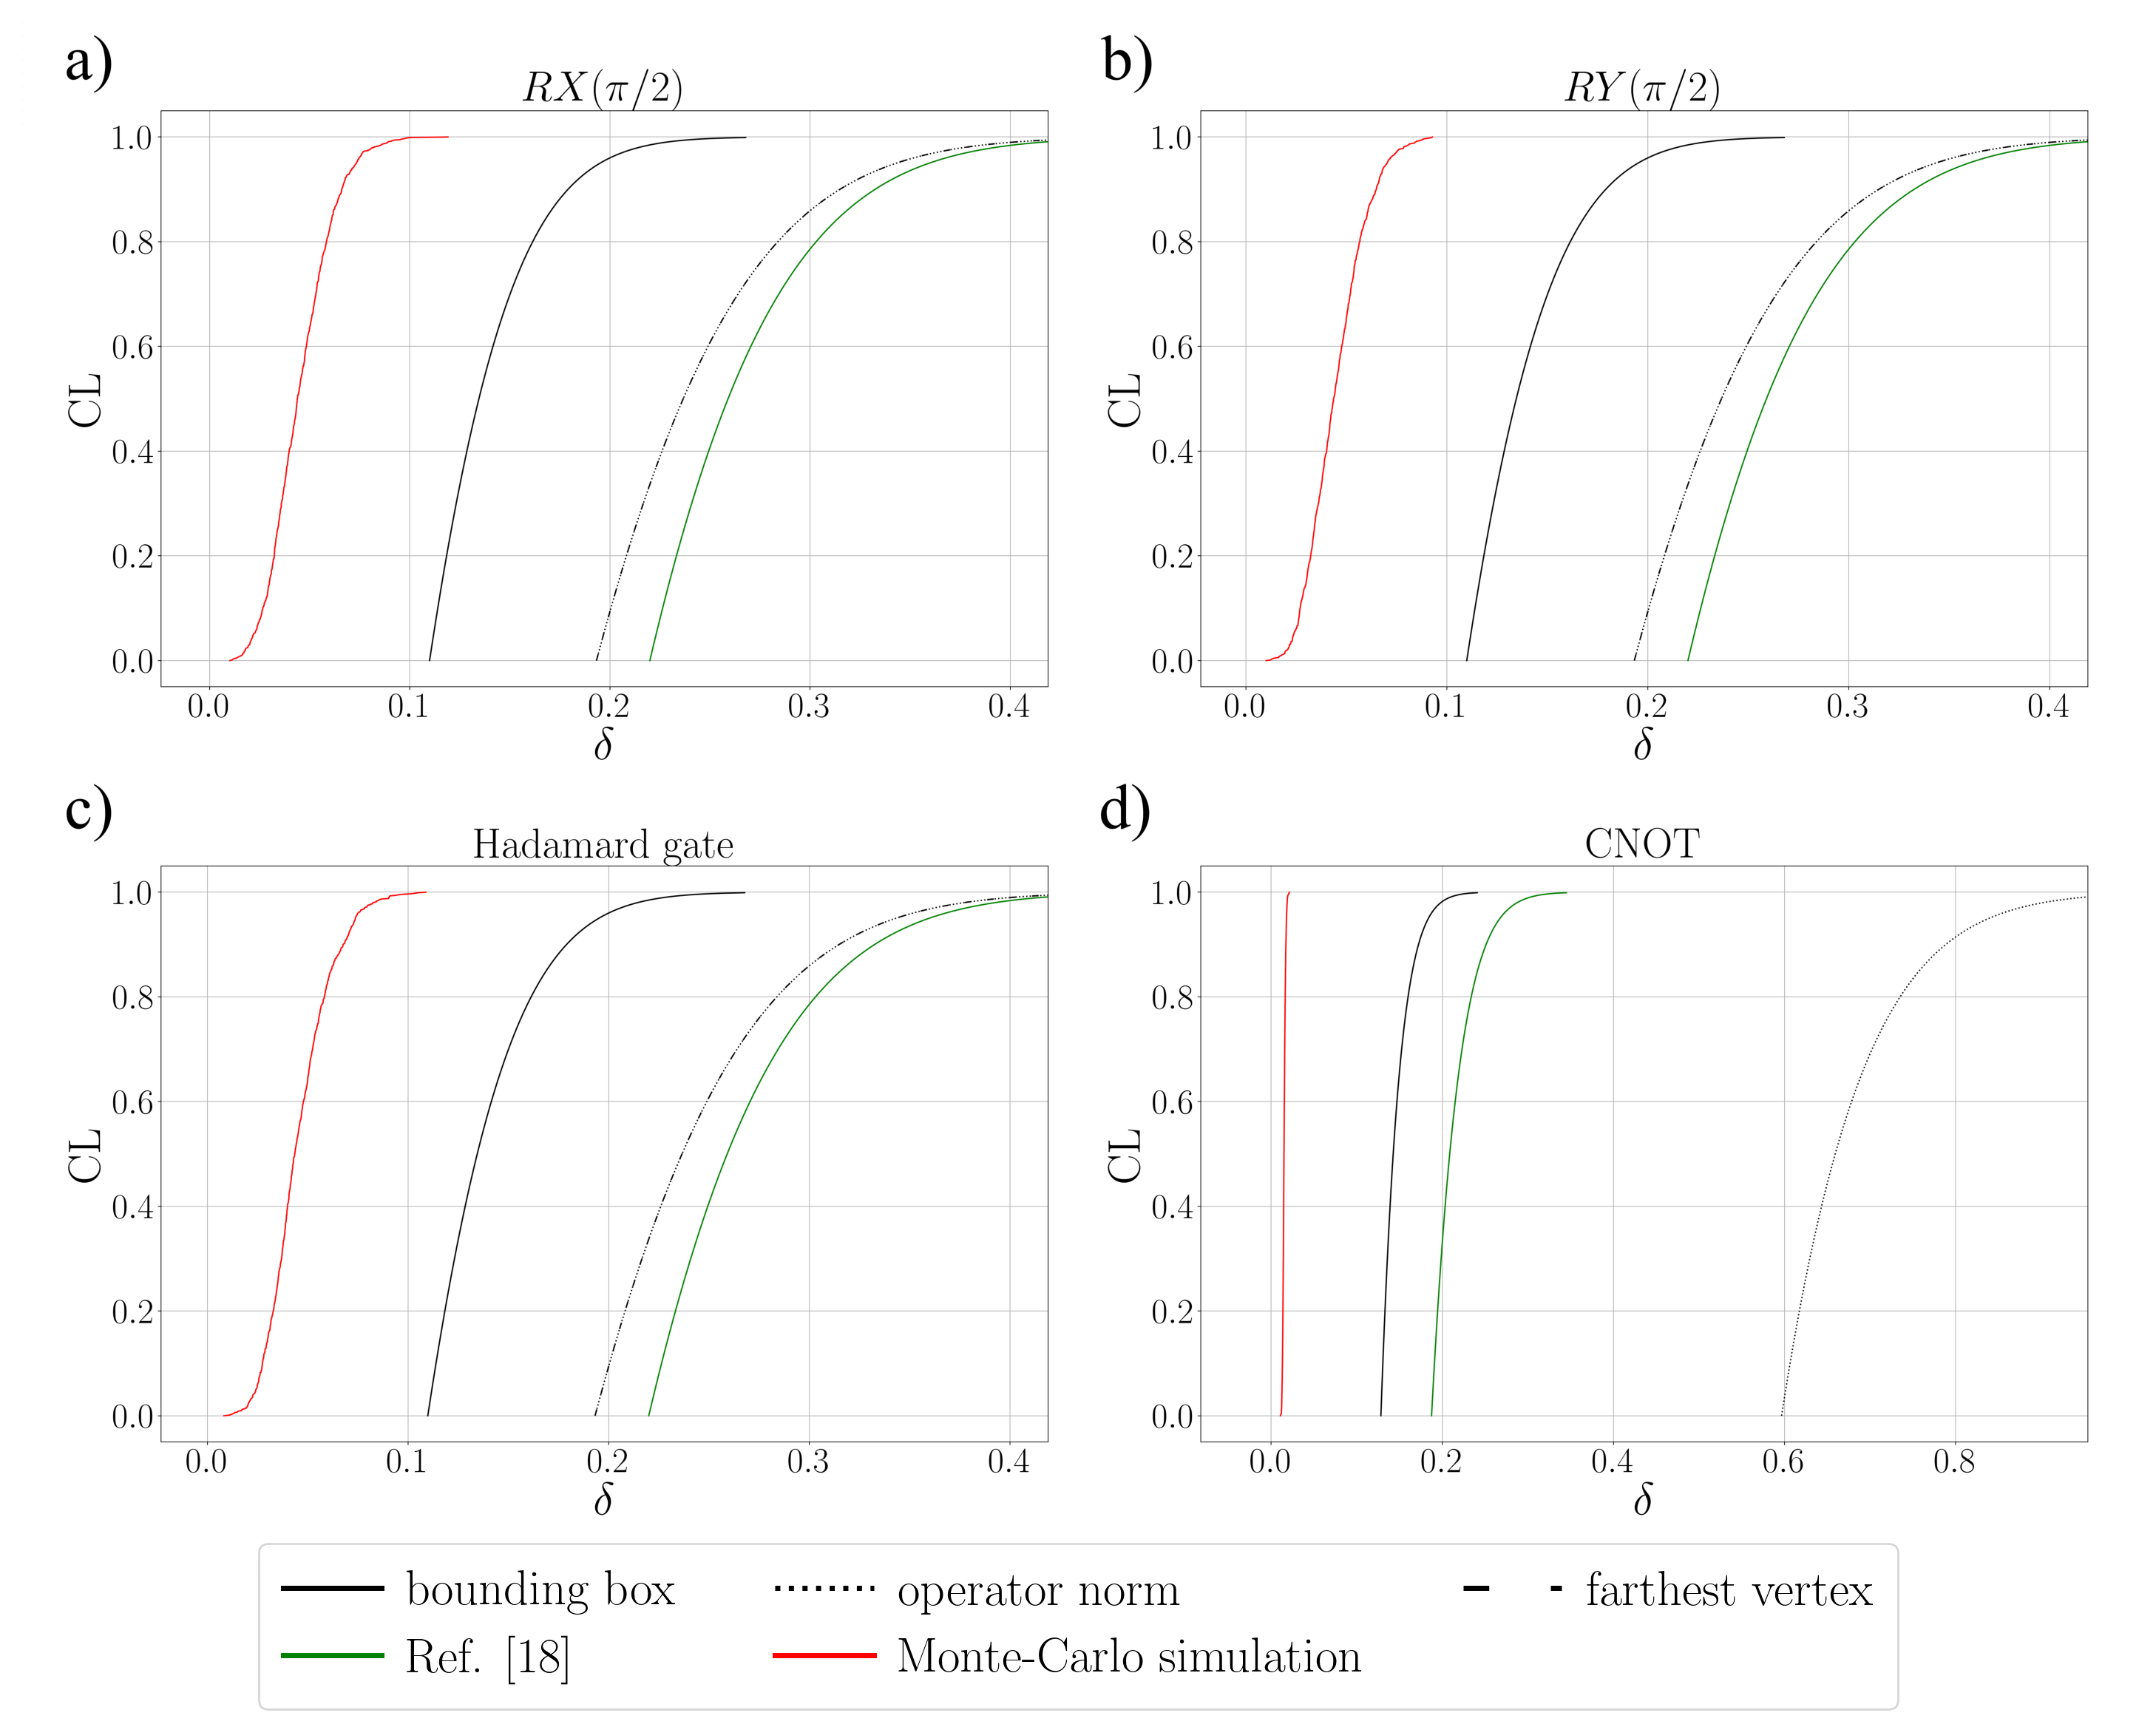

In [60]:
plt.figure(figsize=(20, 14), dpi=200)

image = plt.imread('../imgs/polytopes_paper/process/fig1.png')
plt.axis('off')
plt.imshow(image)
plt.legend(handles=legend_elements, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize=24)
plt.savefig('../imgs/polytopes_paper/process/fig_legend.png')
plt.show()

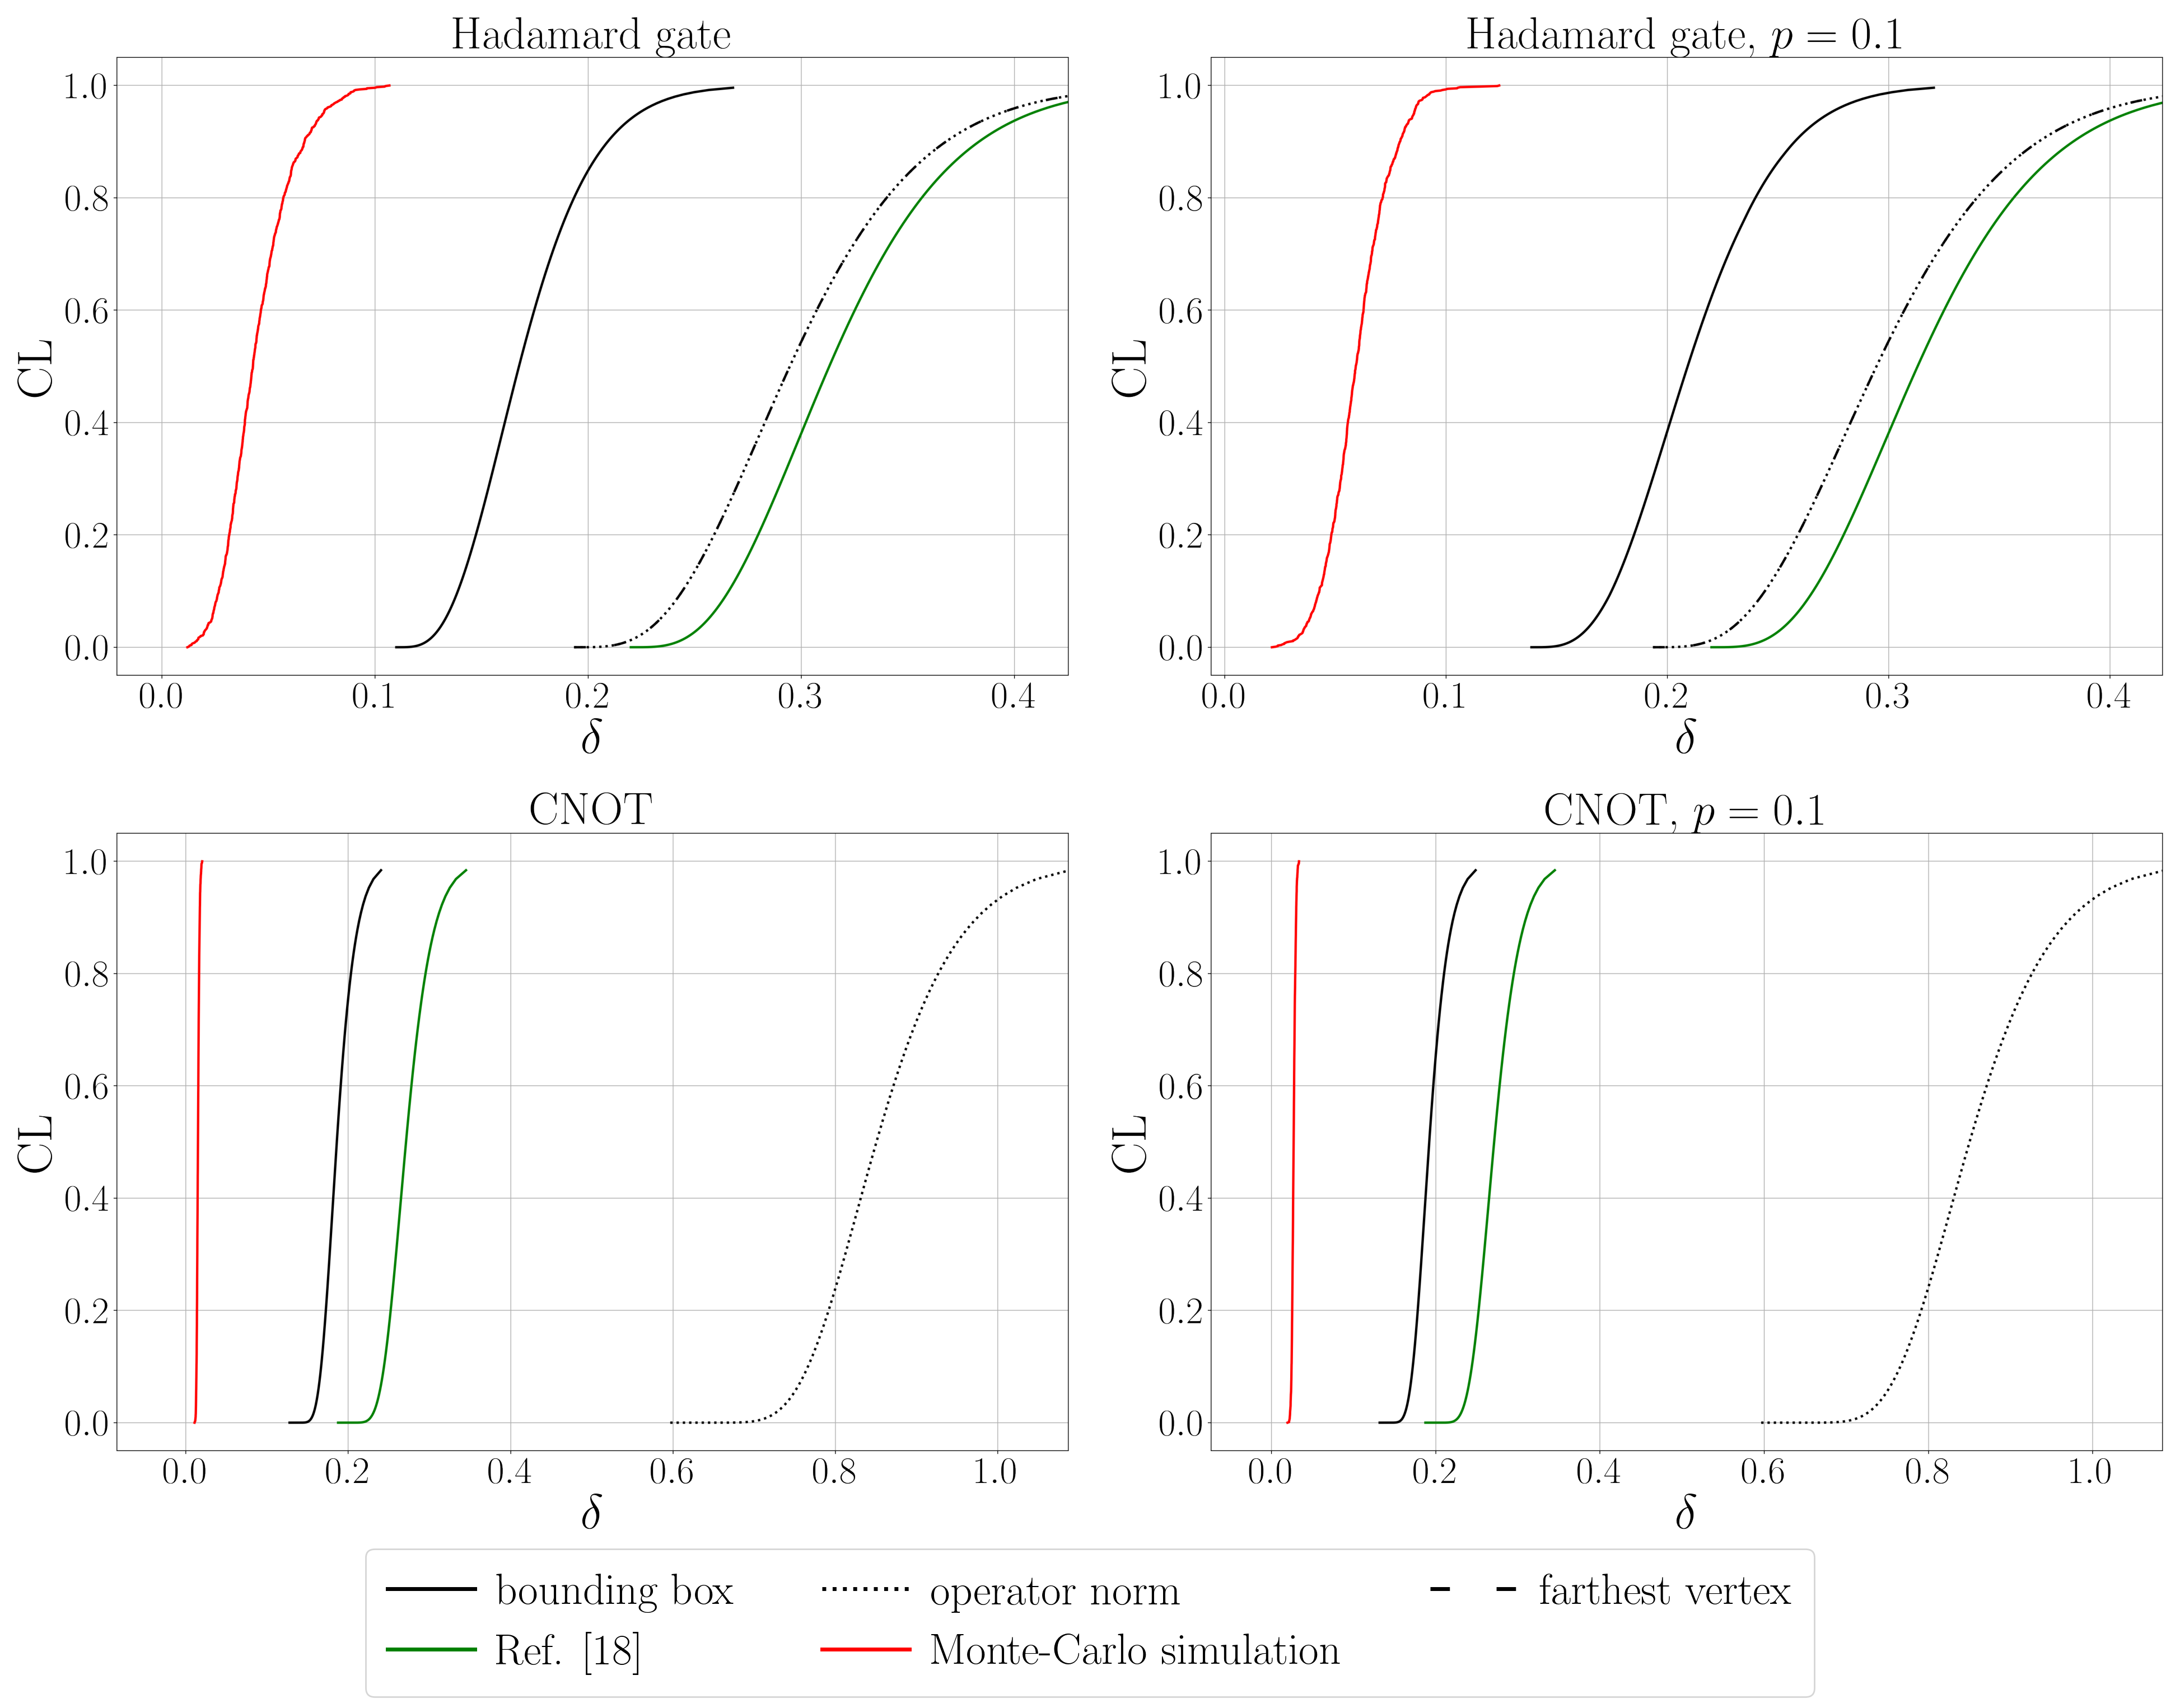

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(20, 14), dpi=200)

image = plt.imread('../imgs/polytopes_paper/process/hadamard.png')
ax[0][0].axis('off')
ax[0][0].imshow(image)

image = plt.imread('../imgs/polytopes_paper/process/hadamard_0.1.png')
ax[0][1].axis('off')
ax[0][1].imshow(image)

image = plt.imread('../imgs/polytopes_paper/process/cnot.png')
ax[1][0].axis('off')
ax[1][0].imshow(image)

image = plt.imread('../imgs/polytopes_paper/process/cnot_0.1.png')
ax[1][1].axis('off')
ax[1][1].imshow(image)

fig.tight_layout()
fig.legend(handles=legend_elements, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize=28)

plt.savefig('../imgs/polytopes_paper/process/fig1.png', bbox_inches='tight')
plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


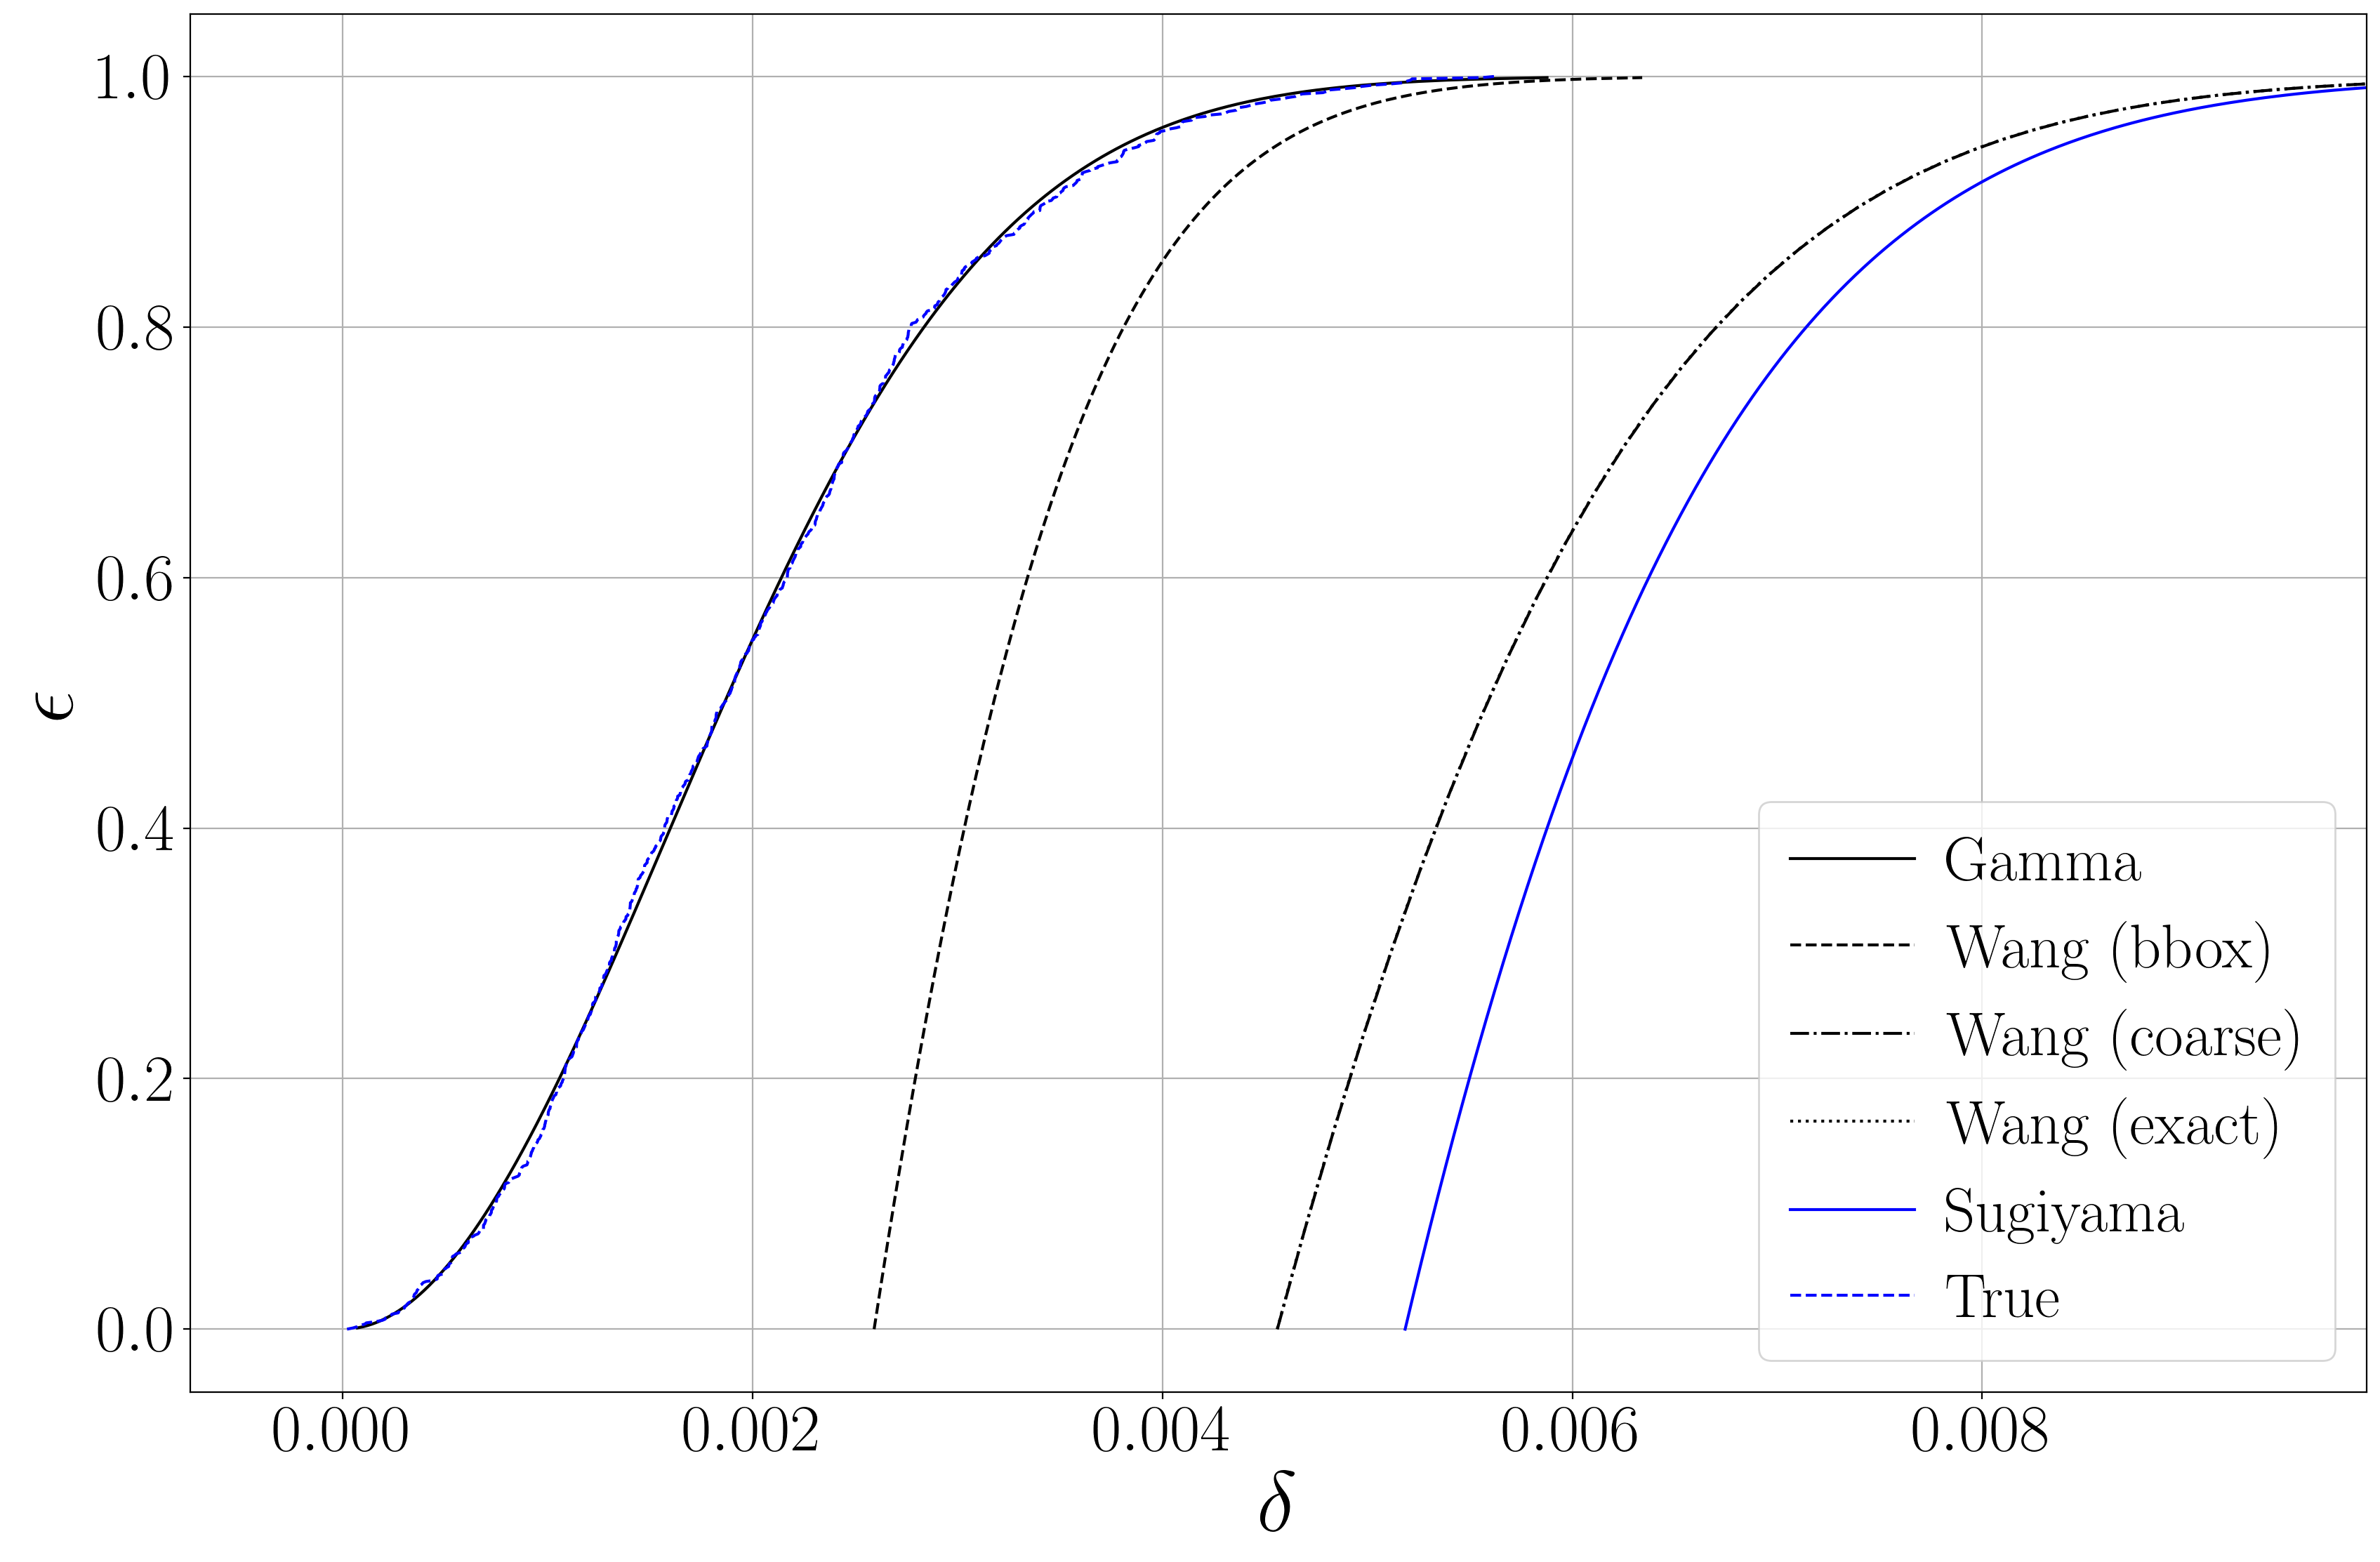

In [4]:
state = qp.qobj.GHZ(1)
tmg = qp.StateTomograph(state)
tmg.experiment(100000, povm='proj-set')
state_hat = tmg.point_estimate('lin')
intervals = {
    'Gamma': qp.GammaInterval(tmg),
    'Wang (bbox)': qp.WangInterval(tmg, method='bbox'),
    'Wang (coarse)': qp.WangInterval(tmg, method='coarse'),
    'Wang (exact)': qp.WangInterval(tmg, method='exact'),
    'Sugiyama': qp.SugiyamaInterval(tmg),
    'True': qp.BootstrapStateInterval(tmg, state=state, n_points=1000),
}
results, times = plot_intervals(intervals)

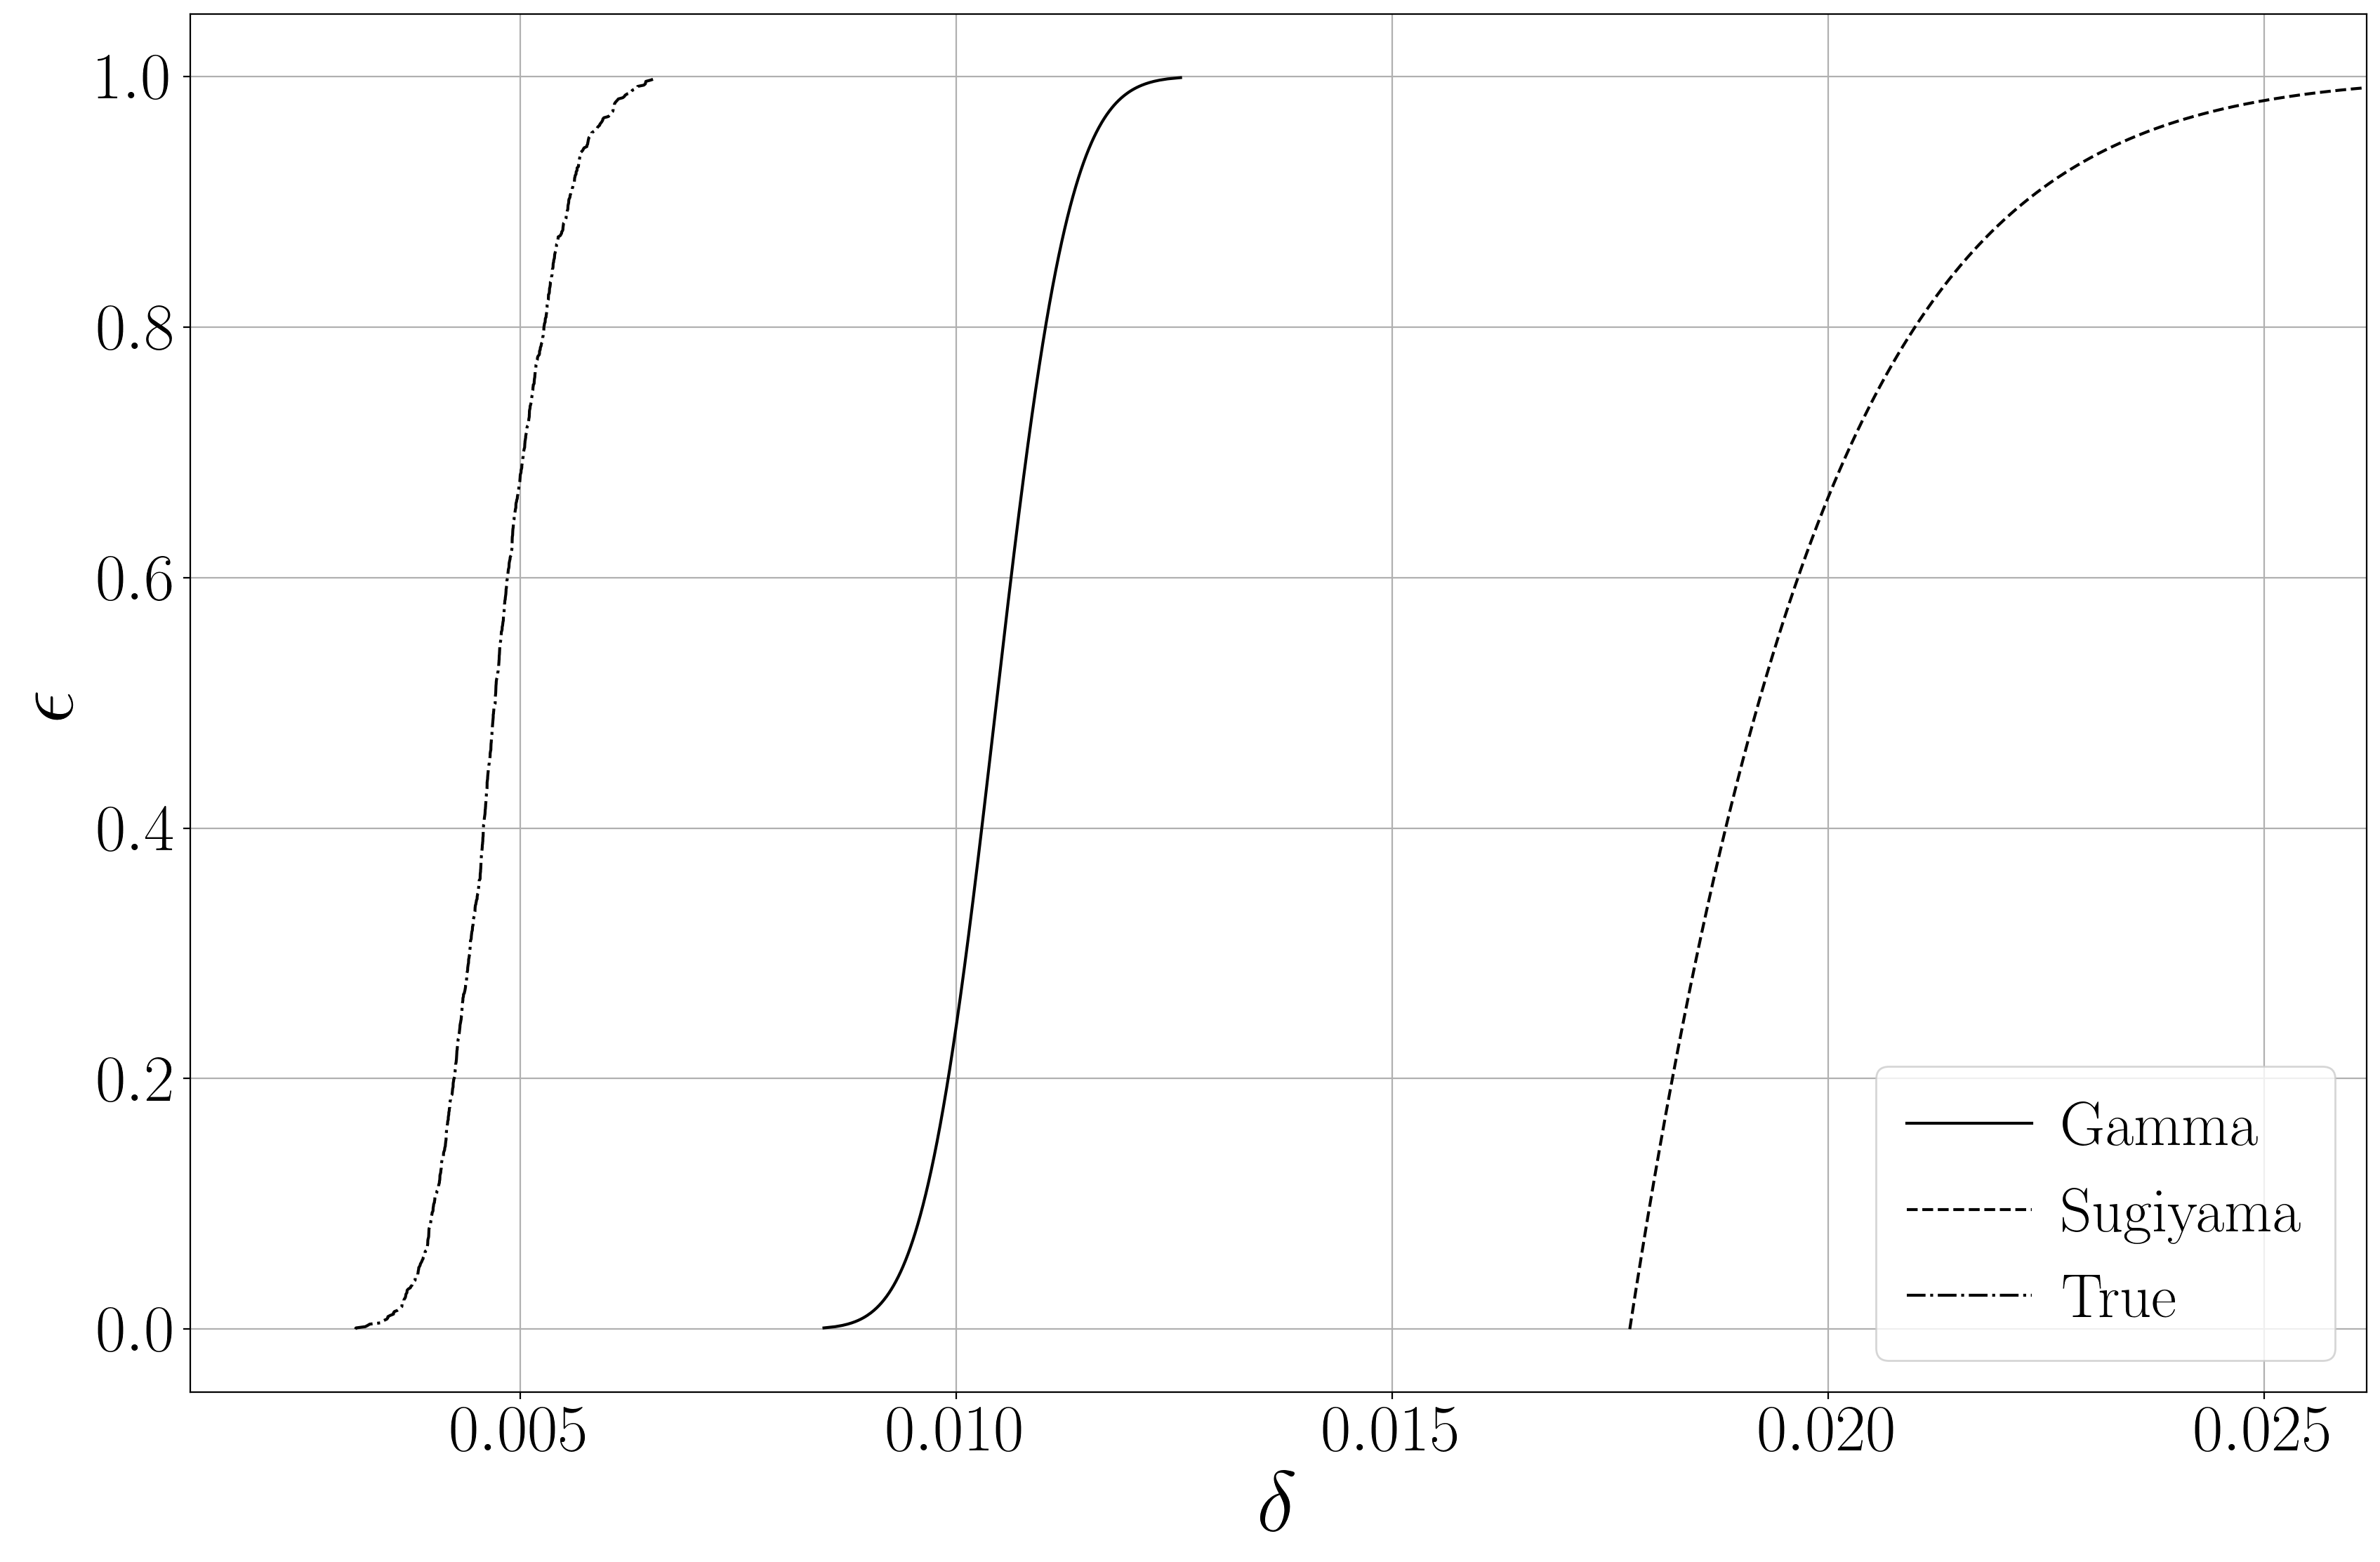

In [7]:
state = qp.qobj.GHZ(3)
tmg = qp.StateTomograph(state)
tmg.experiment(100000, povm='proj-set')
state_hat = tmg.point_estimate('lin')
intervals = {
    'Gamma': qp.GammaInterval(tmg),
#     'Wang (bbox)': qp.WangInterval(tmg, method='bbox'),
    'Sugiyama': qp.SugiyamaInterval(tmg),
    'True': qp.BootstrapStateInterval(tmg, state=state, n_points=1000),
}
results, times = plot_intervals(intervals)

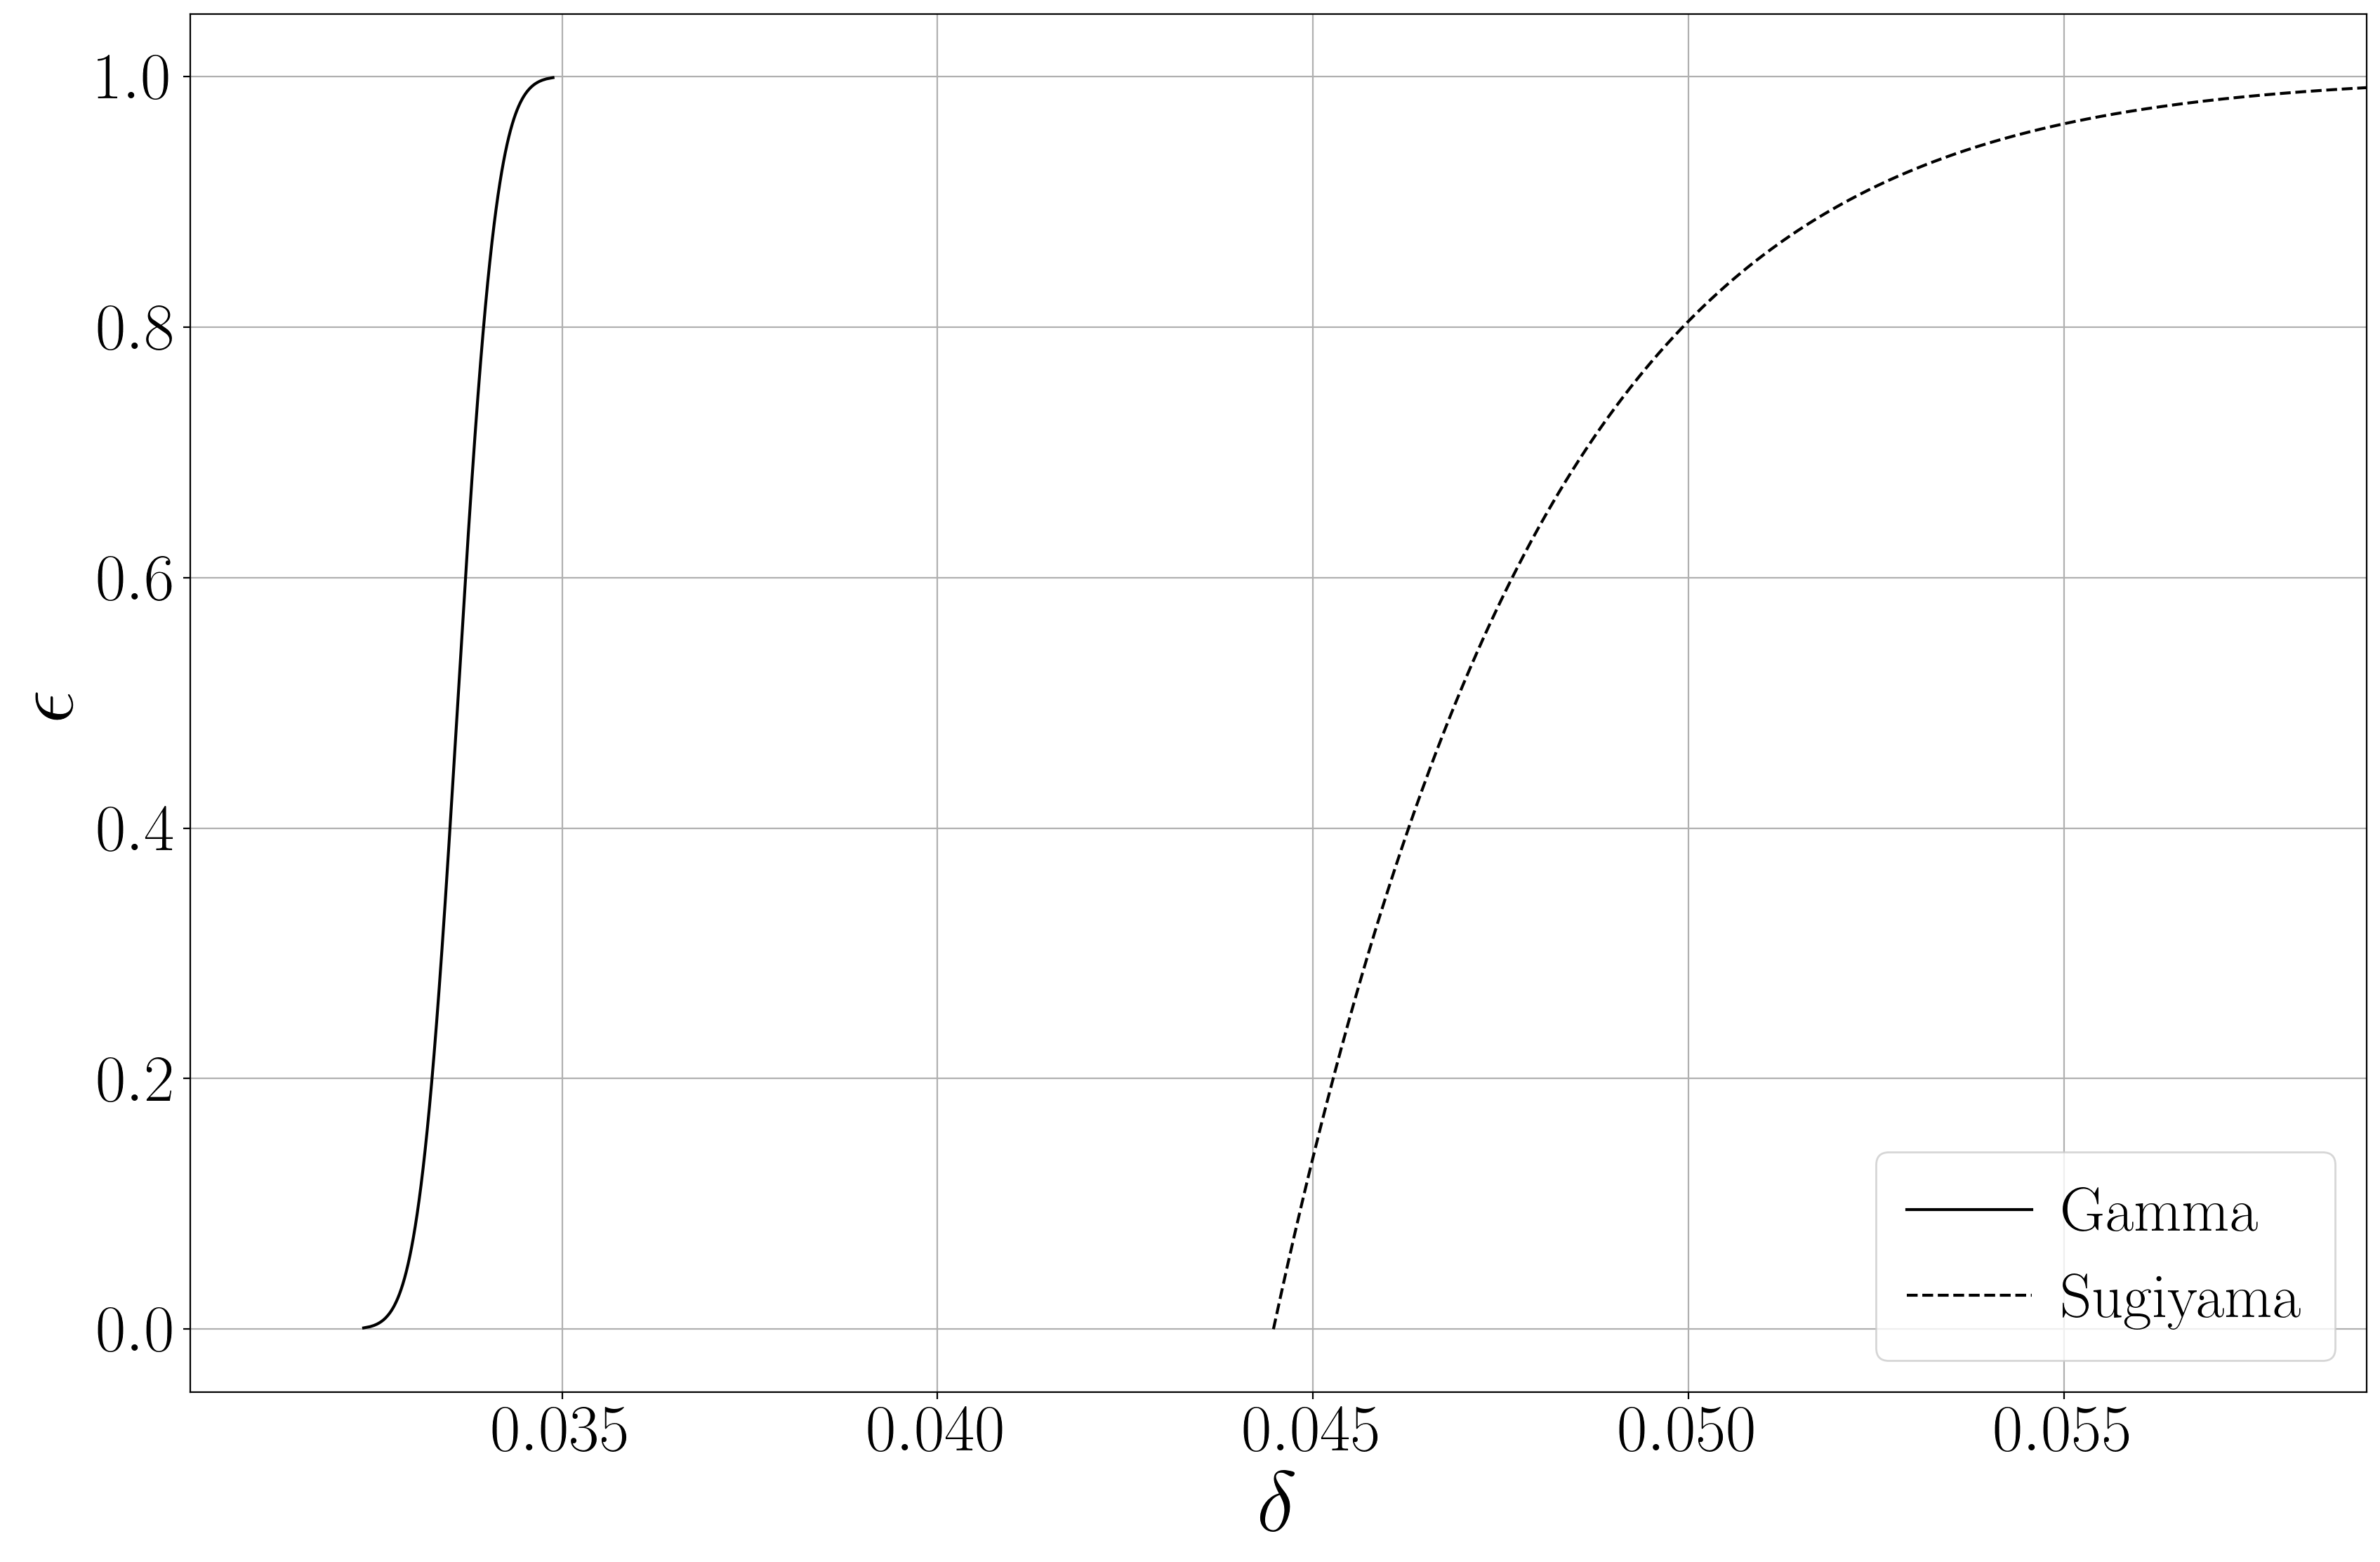

In [5]:
state = qp.qobj.GHZ(5)
tmg = qp.StateTomograph(state)
tmg.experiment(100000, povm='proj-set')
state_hat = tmg.point_estimate('lin')
intervals = {
    'Gamma': qp.GammaInterval(tmg),
#     'Wang (bbox)': qp.WangInterval(tmg, method='bbox'),
    'Sugiyama': qp.SugiyamaInterval(tmg),
#     'True': qp.BootstrapStateInterval(tmg, state=state, n_points=5),
}
results, times = plot_intervals(intervals)

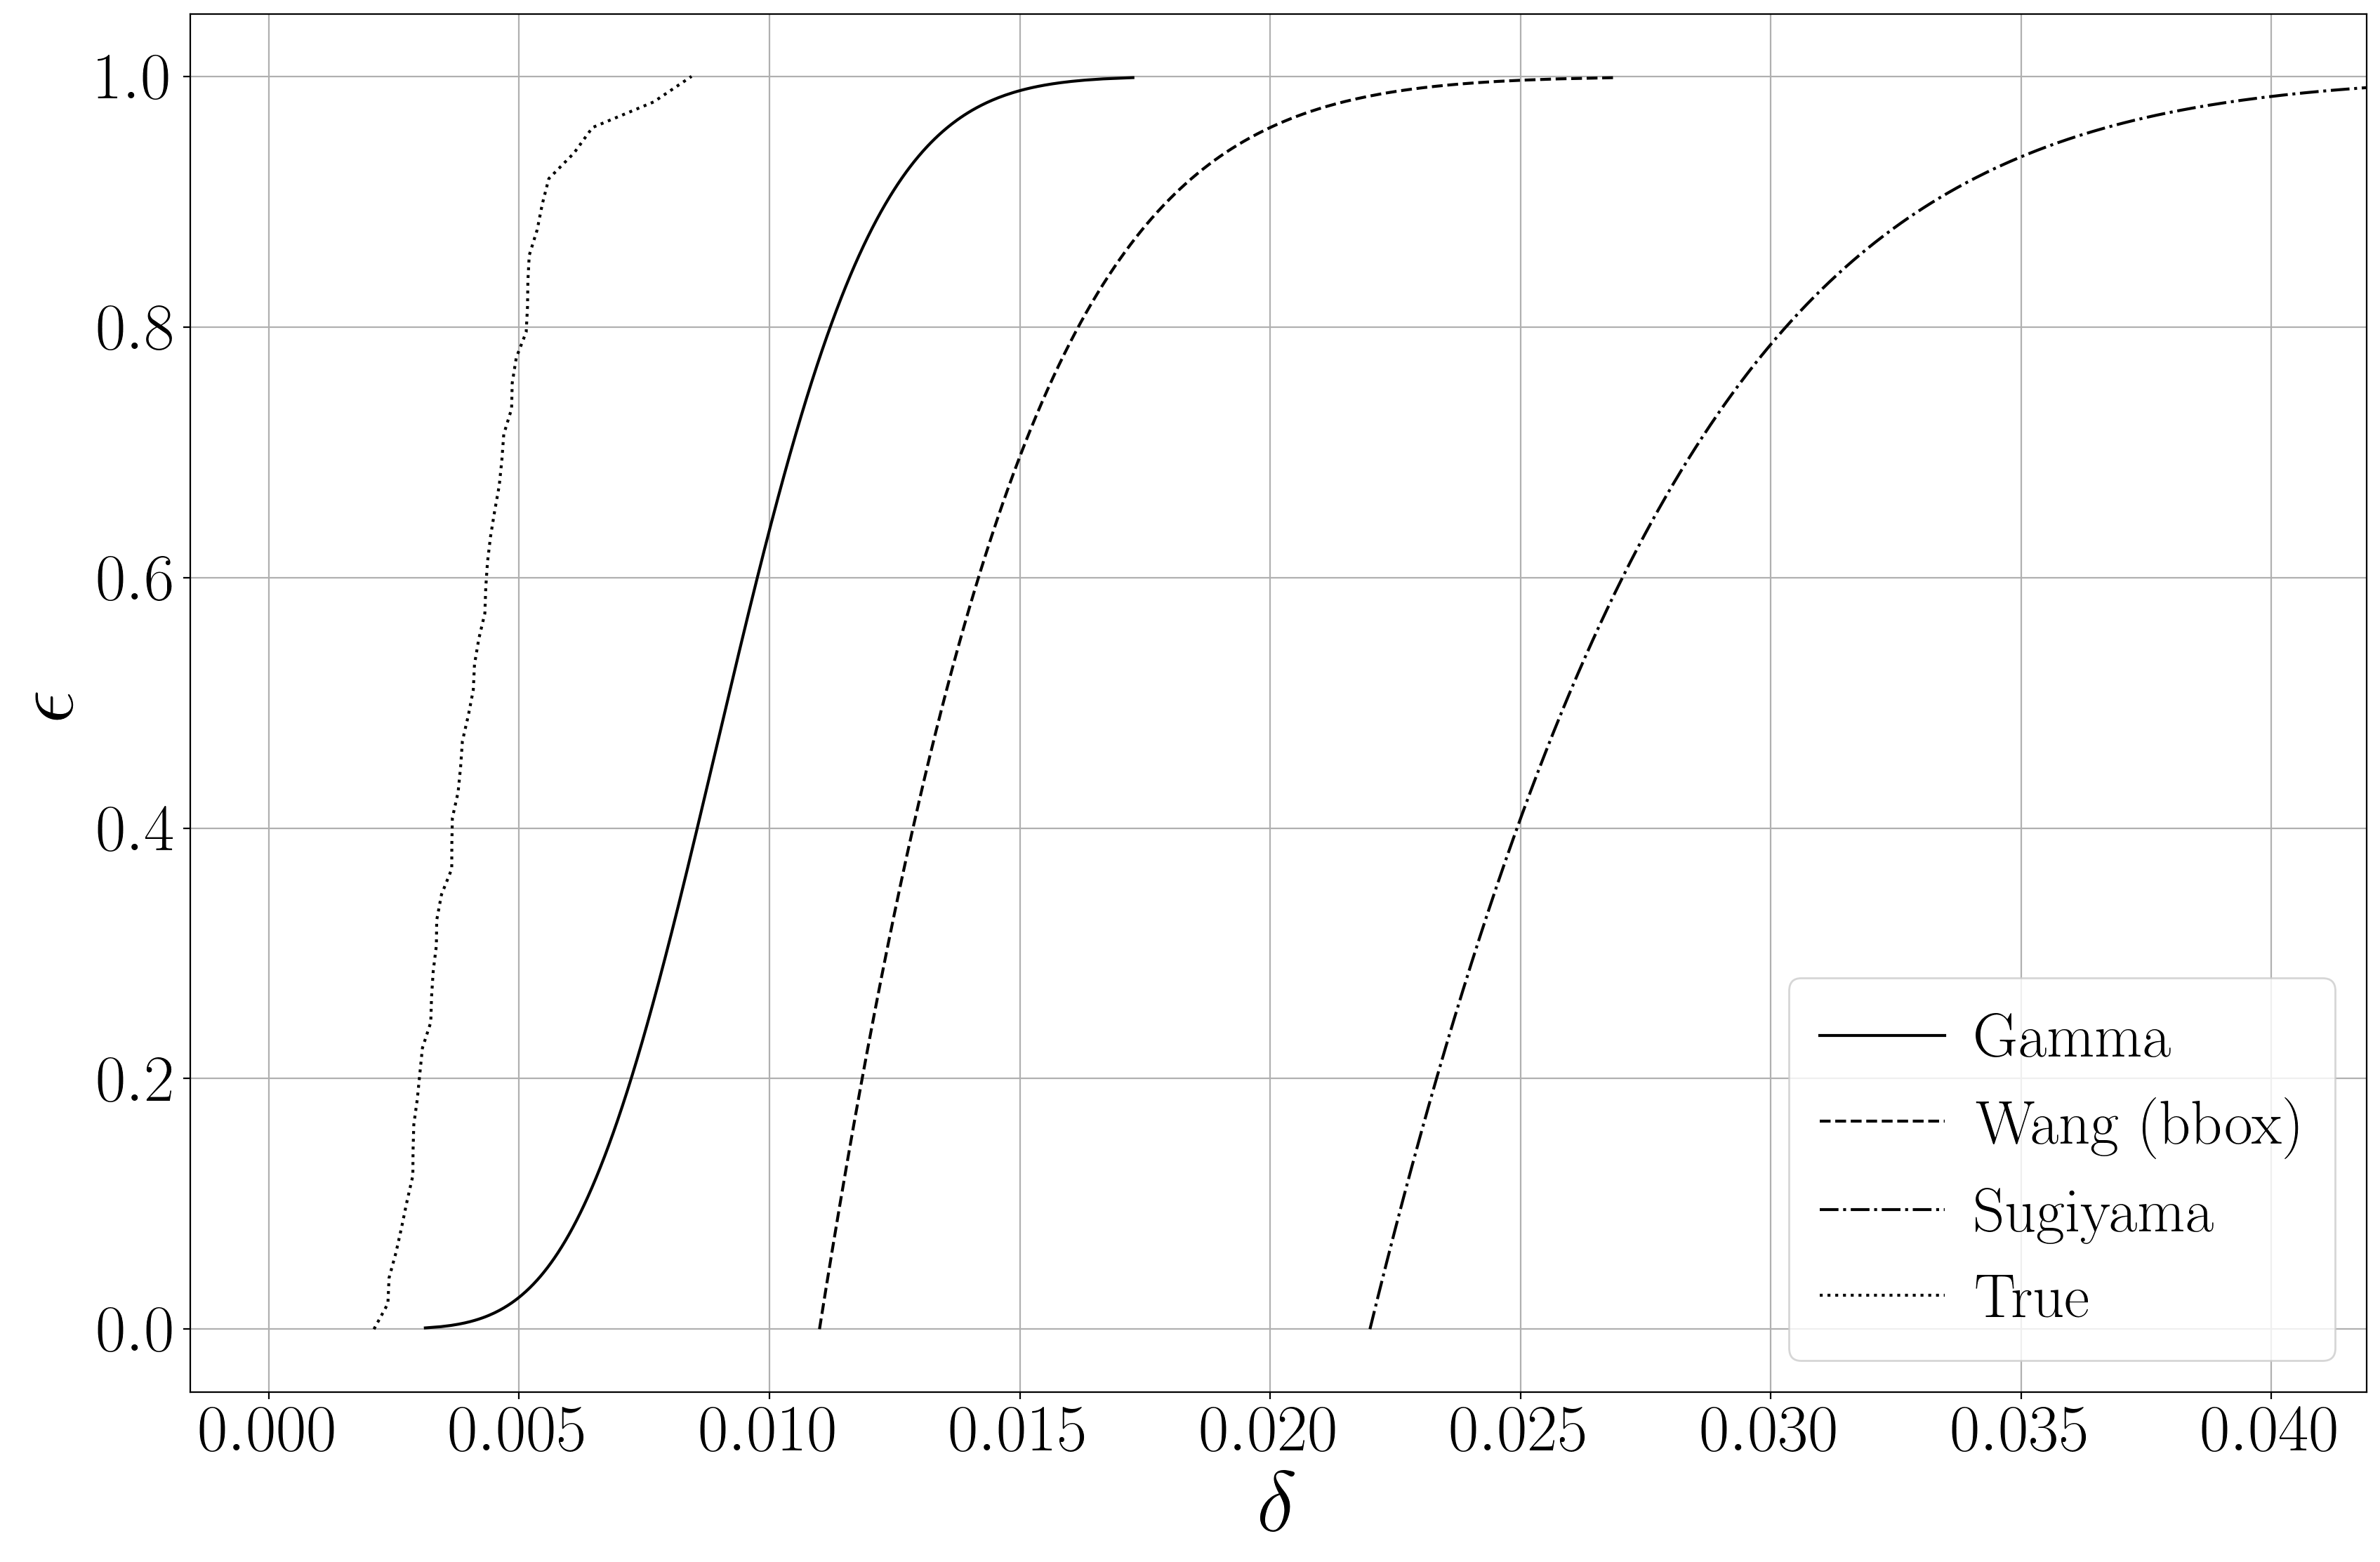

In [14]:
channel = qp.operator.H.as_channel()
tmg = qp.ProcessTomograph(channel)
tmg.experiment(100000, povm='proj-set')
channel_hat = tmg.point_estimate()
intervals = {
    'Gamma': qp.GammaInterval(tmg),
    'Wang (bbox)': qp.HolderInterval(tmg, kind='wang', wang_method='bbox'),
    'Sugiyama': qp.HolderInterval(tmg, kind='sugiyama'),
    'True': qp.BootstrapProcessInterval(tmg, channel=channel, n_points=50),
}
results, times = plot_intervals(intervals)